# Preliminaries

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from tqdm.notebook import tqdm
from datetime import date, timedelta
from pandas_datareader import data as pdr
import yfinance as yf
np.random.seed(42)

# Google stock data

In [2]:
yf.pdr_override()
start = date(2021, 1, 1)
end = date(2022, 1, 1)
googlframe = pdr.get_data_yahoo("GOOGL", start="2020-01-01", end="2021-01-01")
display(googlframe.head())
display(googlframe.tail())

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-01-02  67.420502  68.433998  67.324501  68.433998  68.433998  27278000
2020-01-03  67.400002  68.687500  67.365997  68.075996  68.075996  23408000
2020-01-06  67.581497  69.916000  67.550003  69.890503  69.890503  46768000
2020-01-07  70.023003  70.175003  69.578003  69.755501  69.755501  34330000
2020-01-08  69.740997  70.592499  69.631500  70.251999  70.251999  35314000

Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-12-24  86.449997  87.120499  86.217499  86.708000  86.708000   9312000
2020-12-28  87.245499  89.349998  87.091003  88.697998  88.697998  27650000
2020-12-29  89.361504  89.423500  87.755501  87.888000  87.888000  19726000
2020-12-30  88.250000  88.388000  86.400002  86.812500  86.812500  21026000
2020-12-31  86.863503  87.875000  86.804497  87.632004  87.632004  21070000

<AxesSubplot:xlabel='Date'>

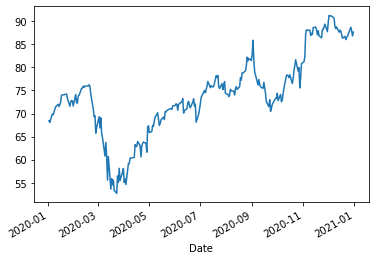

In [3]:
googlframe['Adj Close']['2020-01-01':'2021-01-01'].plot()

# SDE

$d S_{t}= r S_{t} d t+\sigma S_{t} dW_{t}$

In [4]:
from numpy import sqrt, exp, cumsum, sum, maximum, mean
from numpy.random import standard_normal

# Parameters

In [5]:
S0 = 100   # initial price
K = 100      # strike price
r = 0.01     # risk-free interest rate
sigma = 0.15 # volatility
T0 = date.today() # today's date
T1 = date(2023,12,1)  # start date of asian option average
T2 = date(2023,12,31) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
dt = T/N     # time step size
M = 1000     # number of simulations

In [6]:
print(T)
print(N)
print(dt)
print((T1-T0).days)
(T2-T1).days

0.40273972602739727
147
0.0027397260273972603
117


30

# Base class for random walk models

In [7]:
class BaseSimulator:
    def __init__(self, model_name, S0, K, r, sigma, T, N, M, T0, T2, phis=[]):
        self.model_name = model_name
        self.S0 = S0  # initial price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # time to maturity in years
        self.N = N    # number of time steps
        self.dt = T/N # time step size
        self.M = M    # number of simulations
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.realisations = None    # full path of realisations
        self.av_realisations = None # antithetic variate paths
        self.expiry_prices = None # expiry prices
        self.phis = phis # sequence of noise
        self.option_price = None # estimated option price
        self.payoffs = None # payoffs of each simulation
        self.antithetic_variates = False
        self.av_option_price = None # estimated option price with antithetic variate
        self.av_payoffs = None

    def get_option_price(self, option_type="c"):
        """
        calculate payoffs and dicounted option price
        
        Parameters:
            option_type (str): c -> call option, p -> put option
        """
        self.expiry_prices = self.realisations[-1]
        payoffs = (self.expiry_prices - self.K) if (option_type=="c") else (self.K - self.expiry_prices)
        self.payoffs = maximum(payoffs, 0)

        if (self.antithetic_variates==True):
            av_expiry_prices = self.av_realisations[-1]
            av_payoffs = (av_expiry_prices - self.K) if (option_type=="c") else (self.K - av_expiry_prices)
            av_payoffs = maximum(av_payoffs, 0)
            self.av_payoffs = 0.5 * (self.payoffs + av_payoffs)
            self.av_option_price = np.exp(-self.r*self.T) * sum(self.av_payoffs)/self.M
            return self.av_option_price
        else:
            self.option_price = exp(-self.r*self.T) * sum(self.payoffs)/self.M
            return self.option_price
    
    def sample_path_model(self):
        # function for defining how asset sample path should be generated
        raise NotImplementedError("Subclass must implement abstract method")

    def generate_sample_paths(self, antithetic_variates=False):
        """
        function for generating random walks/realisations
        
        Parameters:
            antithetic_variates (bool): activate antithetic variate method
        """        
        # initialise arrays of random variables
        if (len(self.phis) == 0):
            self.phis = np.random.normal(0, 1, size=(self.N, self.M))
        
        # generate sample paths with the specified path generating model
        self.antithetic_variates = antithetic_variates
        self.sample_path_model()
    
    def plot_n_realisations(self, n=0, display_mode=0):
        """
        Parameters:
            n (int): number of sample paths to plot
            display_mode (int): 0 -> plot standard realisations
                                1 -> plot realisations of antithetic varaites
                                2 -> plot both realisations
        """
        
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
        if (display_mode==1):
            plt.plot(timeline, self.av_realisations[:, :n])
        elif (display_mode==2):
            plt.plot(timeline, self.realisations[:, :n], color='blue')
            plt.plot(timeline, self.av_realisations[:, :n], color='orange')
            plt.plot(self.T0, self.S0, color='blue', label="standard")
            plt.plot(self.T0, self.S0, color='orange', label="antithetic variate")
            plt.legend()
        else:
            plt.plot(timeline, self.realisations[:, :n])

        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title(f'Simulated Time Series using {self.model_name} method')
        plt.show()

# Closed Form Solution for vanilla European options

$S_T=S_0 \exp \left\{\left(r-\frac{1}{2} \sigma^2\right) T+\sigma \phi \sqrt{T}\right\}$  
This is a closed form solution where the final price at expiry can be calculated in one giant step T.  
Integrated over [0,T]

In [8]:
# initialise random values
phi = standard_normal(M)

# Simulate I outcome
S = S0 * exp((r - 0.5 * sigma ** 2) * T + sigma * sqrt(T) * phi)
payoffs = maximum(S-K, 0)

# Calculate the Monte Carlo estimator
C0 = exp(-r * T) * sum(payoffs)/len(payoffs)
print("Estimated present value is %f" % C0)

Estimated present value is 4.001022


In [387]:
def N_(x):
    # Define the standard normal distribution
    mean = 0
    std_dev = 1
    standard_normal = norm(loc=mean, scale=std_dev)
    return standard_normal.cdf(x)
          
def european_call_option_price(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = S0 * N_(d1) - K * np.exp(-r * T) * N_(d2)
    return call_price

def european_put_option_price(S0, K, r, sigma, T):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    put_price = K * np.exp(-r * T) * N_(-d2) - S0 * N_(-d1)
    return put_price

# Euler discretisation on log price - optimised
$S_{t + \delta t} = S_t e^{\left(r - \frac{1}{2}\sigma^2\right)\delta t + \sigma\phi\sqrt{\delta t}}$  
Time stepping solution following Euler discretisation method, integrate over [$t, t+\delta t$]

In [9]:
class Euler_discretisation_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        drift = (self.r - 0.5*self.sigma**2)*self.dt
        diffusion = self.sigma*np.sqrt(self.dt)*self.phis
        delta_St = drift + diffusion
        self.realisations = self.S0*np.cumprod(np.exp(delta_St), axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = drift - diffusion
            self.av_realisations = self.S0*np.cumprod(np.exp(delta_St_av), axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call option - normal

In [10]:
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler-discretisation", S0, K, r, sigma, T, N, M, T0, T2)
ed_simulator.generate_sample_paths(antithetic_variates=False)
ed_option_price = ed_simulator.get_option_price()
print("Estimated present value is: %f" % ed_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is: 4.091330
Computation time is:  0.0155


### Call option - with antithetic variate method

In [11]:
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler-discretisation", S0, K, r, sigma, T, N, M, T0, T2)
ed_simulator.generate_sample_paths(antithetic_variates=True)
ed_option_price = ed_simulator.get_option_price()
print("Estimated present value is: %f" % ed_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is: 4.024552
Computation time is:  0.0148


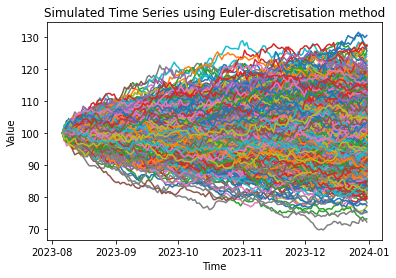

In [12]:
# plot the original set of realisations
ed_simulator.plot_n_realisations()

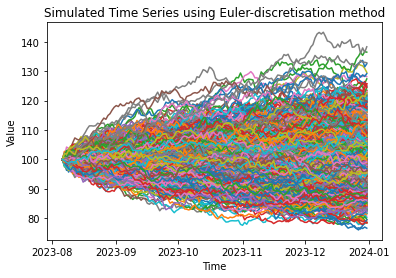

In [13]:
# plot realisations of antithetic varites
ed_simulator.plot_n_realisations(display_mode=1)

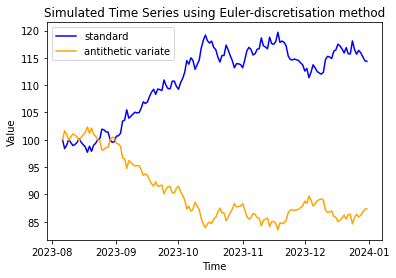

In [14]:
# plot both original and antithetic realisations for verification purpose
ed_simulator.plot_n_realisations(n=1, display_mode=2)

# Forward Euler-Maruyama method - optimised
$S_{t+\delta t} = S_t(1+r \delta t+\sigma \phi \sqrt{\delta t})$

In [15]:
class Euler_Maruyama_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*(-self.phis)
            self.av_realisations = self.S0*np.cumprod(delta_St_av, axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call Option

In [16]:
start_time = time.time()
em_simulator_call = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator_call.generate_sample_paths(antithetic_variates=True)
em_call_option_price = em_simulator_call.get_option_price()
print("Estimated present value is %f" % em_call_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 3.991073
Computation time is:  0.0191


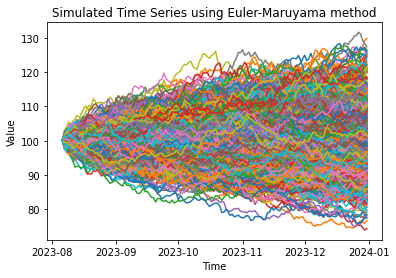

In [17]:
em_simulator_call.plot_n_realisations()

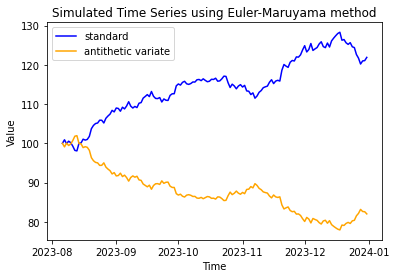

In [18]:
em_simulator_call.plot_n_realisations(n=1, display_mode=2)

### Put Option

In [19]:
start_time = time.time()
em_simulator_put = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2)
em_simulator_put.generate_sample_paths(antithetic_variates=True)
em_put_option_price = em_simulator_put.get_option_price("p")
print("Estimated present value is %f" % em_put_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 3.535078
Computation time is:  0.017


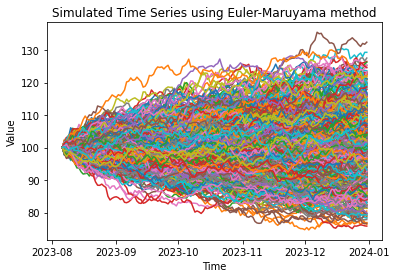

In [20]:
em_simulator_put.plot_n_realisations()

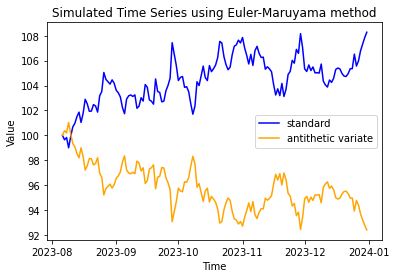

In [21]:
em_simulator_put.plot_n_realisations(n=1, display_mode=2)

# Milstein method - optimised
$S_{t+\delta t} = S_t\left(1+r \delta t+\sigma \phi \sqrt{\delta t}+\frac{1}{2} \sigma^2\left(\phi^2-1\right) \delta t\right)$

In [22]:
class Milstein_fast_simulator(BaseSimulator):
    def sample_path_model(self):
        delta_St = 1 + self.r*self.dt + self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
        self.realisations = self.S0*np.cumprod(delta_St, axis=0)
        # prepend initial price S0 to the realisations
        self.realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.realisations))
        
        # use negative counterpart of the phis to generate antithetic variates
        if (self.antithetic_variates):
            delta_St_av = 1 + self.r*self.dt - self.sigma*np.sqrt(self.dt)*self.phis + 0.5*(self.sigma**2)*(np.square(self.phis)-1)*self.dt
            self.av_realisations = self.S0*np.cumprod(delta_St_av, axis=0)
            # prepend initial price S0 to the realisations
            self.av_realisations = np.concatenate((np.full(shape=(1, self.M), fill_value=self.S0), self.av_realisations))

### Call Option

In [23]:
start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator_call.generate_sample_paths(antithetic_variates=True)
mil_call_option_price = mil_simulator_call.get_option_price()
print("Estimated present value is %f" % mil_call_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 4.019368
Computation time is:  0.0164


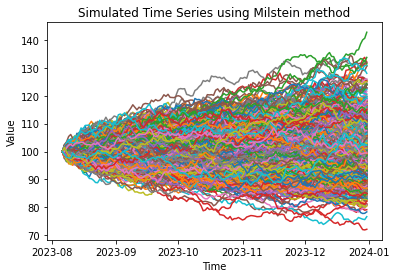

In [24]:
mil_simulator_call.plot_n_realisations()

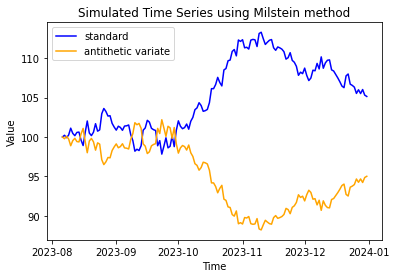

In [25]:
mil_simulator_call.plot_n_realisations(n=1, display_mode=2)

### Put Option

In [26]:
start_time = time.time()
mil_simulator_put = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2)
mil_simulator_put.generate_sample_paths(antithetic_variates=True)
mil_put_option_price = mil_simulator_put.get_option_price("p")
print("Estimated present value is %f" % mil_put_option_price)
print("Computation time is: ", round(time.time() - start_time,4))

Estimated present value is 3.596768
Computation time is:  0.0179


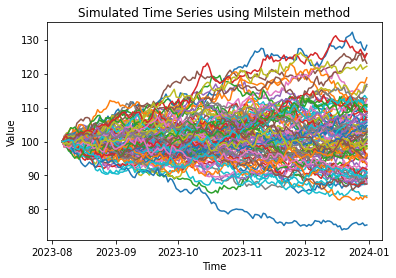

In [27]:
mil_simulator_put.plot_n_realisations(100)

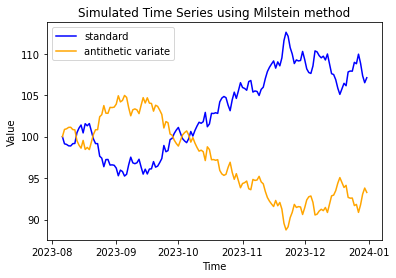

In [28]:
mil_simulator_put.plot_n_realisations(n=1, display_mode=2)

# Monte Carlo simulator - optimised 
The same set of phis is used for Euler-discretisation, Euler-Maruyama and Milstein methods for comparison.

In [29]:
class MC_simulator_optimised:
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, simulator, phis=[]):
        self.S0 = S0  # initial asset price
        self.K = K    # strike price
        self.r = r    # risk-free interest rate
        self.sigma = sigma # volatility
        self.T = T    # Final time
        self.N = N    # number of time steps
        self.M = M    # number of simulations
        self.T0 = T0  # start date
        self.T2 = T2  # maturity date
        self.dt = T/N # time step size
        self.simulator  = simulator # asset path generator
        self.phis = phis # sequence of noise
        self.mil_simulator = None
        self.em_simulator = None
        self.ed_simulator = None
        self.antithetic_variates = False
        
    def standard_error(self, payoffs, option_price):
        # sample standard deviation
        std_dev = np.sqrt(np.sum((exp(-self.r*self.T)*payoffs - option_price)**2) / (self.M-1))
        
        # standard error
        SE = std_dev/np.sqrt(self.M)
        return SE
    
    def get_European_option_price(self, option_type):
        # price the option
        option_price = self.simulator.get_option_price(option_type)
        SE = 0
        if (self.antithetic_variates):
            SE = self.standard_error(self.simulator.av_payoffs, self.simulator.av_option_price)
        else:
            SE = self.standard_error(self.simulator.payoffs, self.simulator.option_price)
        return (option_price, SE)
        
    def run_monte_carlo(self, antithetic_variates):
        self.antithetic_variates = antithetic_variates
        self.simulator.generate_sample_paths(antithetic_variates)

    def update_model(self, simulator_model):
        self.simulator = simulator_model
        

    def comparing_ith_realisations(self, simulators, ith_rls):
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.figure(figsize=(13, 6))
        
        for simulator in simulators:
            plt.plot(timeline, simulator.realisations[:,ith_rls], label=simulator.model_name)
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('Comparing Simulated Time Series using both methods')
        plt.legend()
        plt.show()
    
    def plot_n_realisations(self, simulators, n=0):
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 6))
        n = n if n > 0 else self.M
        timeline = pd.date_range(start=self.T0,end=self.T2)
                
        # plots Euler discretisation realisations
        axes[0, 0].plot(timeline, simulators[0].realisations[:, :n])
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].set_title('Simulated Time Series using Euler discretisation method')
        
        # plots Euler-Maruyama realisations
        axes[0, 1].plot(timeline, simulators[1].realisations[:, :n])
        axes[0, 1].set_xlabel('Time')
        axes[0, 1].set_ylabel('Value')
        axes[0, 1].set_title('Simulated Time Series using Euler-Maruyama method')
        
        # plots Milstein realisations
        axes[1, 0].plot(timeline, simulators[2].realisations[:, :n])
        axes[1, 0].set_xlabel('Time')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].set_title('Simulated Time Series using Milstein method')
        
        axes[1, 1].axis('off')
        fig.tight_layout()
        plt.show()


### European Call Option - plain realisations

In [30]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_call = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=False)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))


Euler discretisation: Estimated present value is 3.5554 with standard error 0.183
Computation time is:  0.0103
Euler Maruyama: Estimated present value is 3.5569 with standard error 0.183
Computation time is:  0.0039
Milstein: Estimated present value is 3.5553 with standard error 0.183
Computation time is:  0.0036


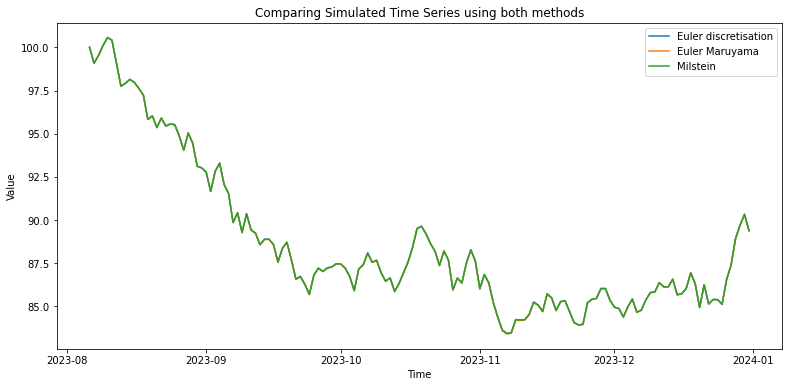

In [31]:
mc_simulator.comparing_ith_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 1)

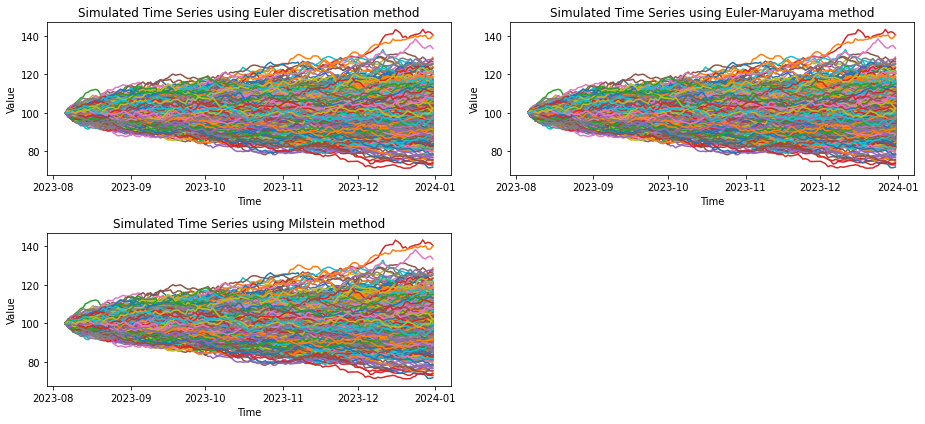

In [32]:
mc_simulator.plot_n_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call])

### European Call Option - realisations with antithetic variate

In [33]:
start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_call = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_call = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_call)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='c')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Euler discretisation: Estimated present value is 3.9106 with standard error 0.105
Computation time is:  0.0265
Euler Maruyama: Estimated present value is 3.9113 with standard error 0.105
Computation time is:  0.0157
Milstein: Estimated present value is 3.9105 with standard error 0.105
Computation time is:  0.0091


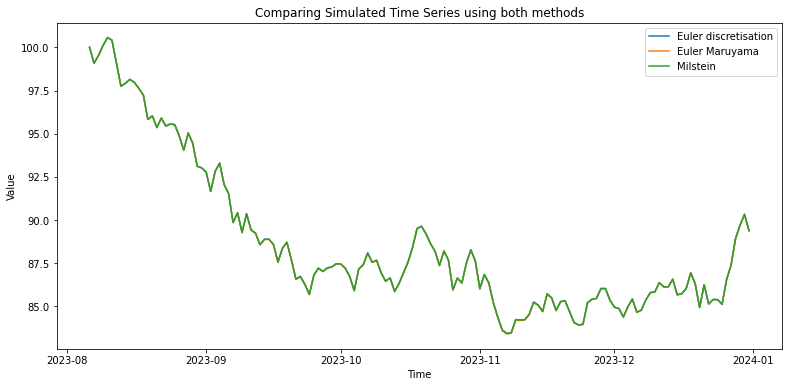

In [34]:
mc_simulator.comparing_ith_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 1)

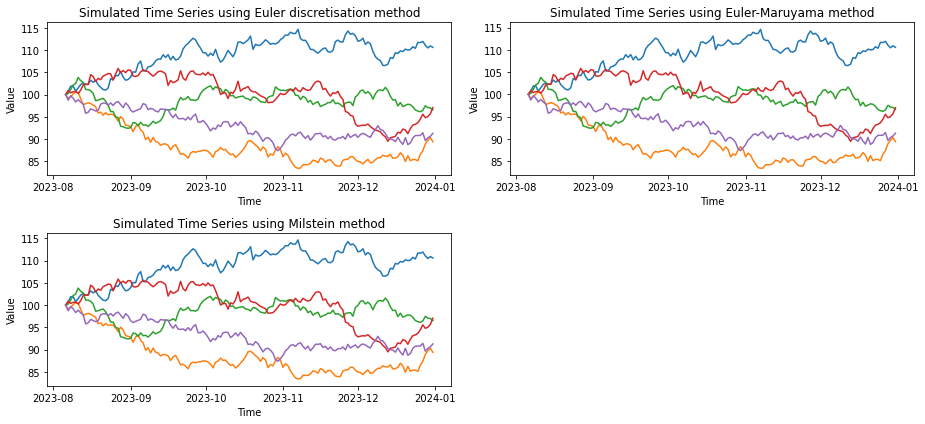

In [35]:
mc_simulator.plot_n_realisations([ed_simulator_call, eu_simulator_call, mil_simulator_call], 5)

### European Put Option - with antithetic variate

In [36]:
start_time = time.time()
ed_simulator_put= Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
eu_simulator_put = Euler_Maruyama_fast_simulator("Euler Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, eu_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Euler Maruyama: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

start_time = time.time()
mil_simulator_put = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
mc_simulator = MC_simulator_optimised(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator_put)
mc_simulator.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = mc_simulator.get_European_option_price(option_type='p')
print("Milstein: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Euler discretisation: Estimated present value is 3.51 with standard error 0.084
Computation time is:  0.0297
Euler Maruyama: Estimated present value is 3.5096 with standard error 0.084
Computation time is:  0.01
Milstein: Estimated present value is 3.5099 with standard error 0.084
Computation time is:  0.0124


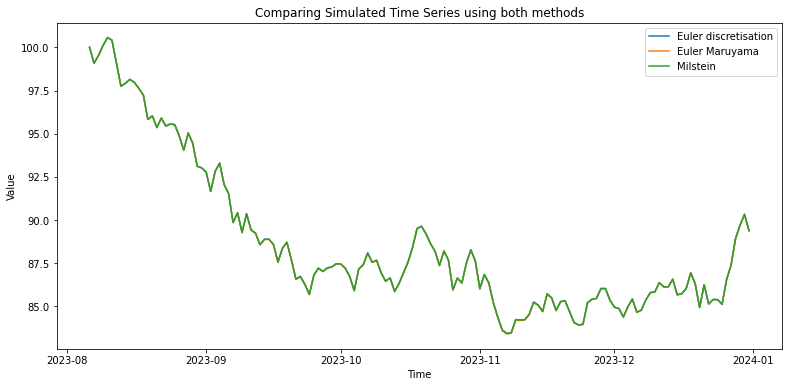

In [37]:
mc_simulator.comparing_ith_realisations([ed_simulator_put, eu_simulator_put, mil_simulator_put], 1)

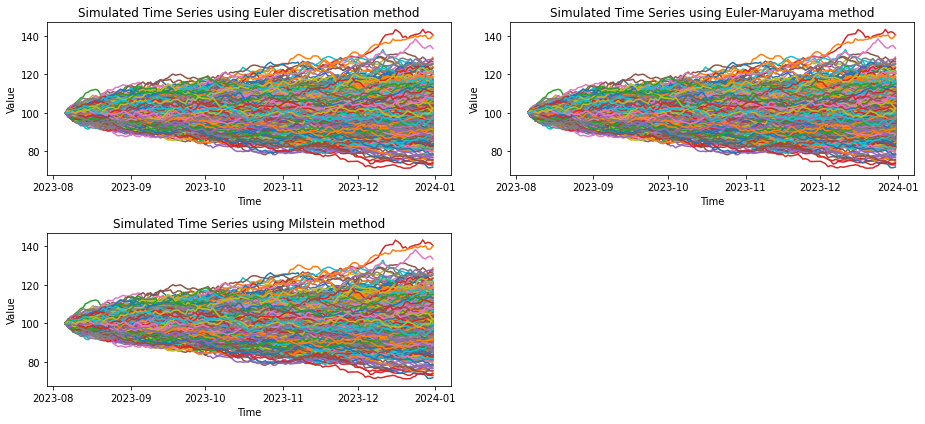

In [38]:
mc_simulator.plot_n_realisations([ed_simulator_put, eu_simulator_put, mil_simulator_put])

# Barrier Options
The BarrierOption() class inherits properties from the MC_simulator_optimised() class, which makes use Monte Carlo method to price Barrier options

1. up-and-in call option
1. up-and-out call option
1. down-and-in call option
1. down-and-out call option
1. up-and-in put option
1. up-and-out put option
1. down-and-in put option
1. down-and-out put option

In [377]:
# Params
S0 = 100   # initial price
S_u = 110  # up barrier
S_d = 90   # down barrier
K = 105      # strike price
r = 0.03     # risk-free interest rate
sigma = 0.2 # voatility
# T0 = date.today() # today's date

T0 = date(2024,1,1)
T2 = date(2024,12,31) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
print(N)
dt = T/N     # time step size
print(dt)
# Barrier correction
S_u_new = S_u * np.exp(0.5863 * sigma * np.sqrt(dt))
print(S_u_new)
S_d_new = S_d * np.exp(-0.5863 * sigma * np.sqrt(dt))
print(S_d_new)

365
0.0027397260273972603
110.67721973007605
89.44930152875641


In [357]:
class BarrierOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, simulator, barrier_type, H_bound, L_bound):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2, simulator)
        self.barrier_type = barrier_type # int: corresponds to the indexes listed above
        self.H_bound = H_bound   # upper barrier
        self.L_bound = L_bound   # lower barrier
        self.mask_1 = None
        self.mask_2 = None
        self.title = 'European Up-and-Out Call Option'
        self.main_type = "Call" if (barrier_type < 5) else "Put"
        self.barrier_price = 0
        self.barrier_payoffs = None
    
    def calculate_option_price(self):
        """
        barrier_type < 5  : call option => ST - K
        barrier_type >= 5 : put option  => K - ST
        """
        S_expiry = self.simulator.realisations[-1,:].copy()
        S_expiry[self.mask_1] = 0
        payoffs = (S_expiry - self.K) if (self.barrier_type < 5) else (self.K - S_expiry)
        payoffs = np.maximum(0, payoffs)
        
        if (self.antithetic_variates):
            S_expiry_2 = self.simulator.av_realisations[-1,:].copy()
            S_expiry_2[self.mask_2] = 0
            payoffs_2 = (S_expiry_2 - self.K) if (self.barrier_type < 5) else (self.K - S_expiry_2)
            payoffs_2 = np.maximum(0, payoffs_2)
            av_payoffs = 0.5*(payoffs + payoffs_2)
            option_price = np.exp(-self.r*self.T)*np.sum(av_payoffs)/self.M
            self.barrier_payoffs = av_payoffs
            return option_price
        else:
            option_price = np.exp(-self.r*self.T)*np.sum(payoffs)/self.M
            self.barrier_payoffs = payoffs
            return option_price
        
    def up_and_in(self):
        self.title = 'European Up-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(self.simulator.realisations >= self.H_bound, axis=0)
        # reversing mask so realisations below barrier are nullified
        self.mask_1 = ~mask
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            mask_2 = np.any(self.simulator.av_realisations >= self.H_bound, axis=0)
            # reversing mask so realisations below barrier are nullified
            self.mask_2 = ~mask_2
        return self.calculate_option_price()
    
    def up_and_out(self):
        self.title = 'European Up-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        self.mask_1 = np.any(self.simulator.realisations >= self.H_bound, axis=0)
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            self.mask_2 = np.any(self.simulator.av_realisations >= self.H_bound, axis=0)
        return self.calculate_option_price()
    
    def down_and_in(self):
        self.title = 'European Down-and-In ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        mask = np.any(self.simulator.realisations <= self.L_bound, axis=0)
        # reversing mask so realisations above barrier are nullified
        self.mask_1 = ~mask
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            mask_2 = np.any(self.simulator.av_realisations <= self.L_bound, axis=0)
            # reversing mask so realisations below barrier are nullified
            self.mask_2 = ~mask_2
        return self.calculate_option_price()

    def down_and_out(self):
        self.title = 'European Down-and-Out ' + ('Call Option' if (self.barrier_type < 5) else 'Put Option')
        # change realisation values to 0 based on indexing mask
        self.mask_1 = np.any(self.simulator.realisations <= self.L_bound, axis=0)
        
        if (self.antithetic_variates):
            # change realisation values to 0 based on indexing mask
            self.mask_2 = np.any(self.simulator.av_realisations <= self.L_bound, axis=0)
        return self.calculate_option_price()

    def get_Barrier_price(self):
        # price option based on barriers
        select_barrier = {
            1 : self.up_and_in,
            2 : self.up_and_out,
            3 : self.down_and_in,
            4 : self.down_and_out,
            5 : self.up_and_in,
            6 : self.up_and_out,
            7 : self.down_and_in,
            8 : self.down_and_out
        }
        self.barrier_price = select_barrier.get(self.barrier_type, self.up_and_in)()
        SE = self.standard_error(self.barrier_payoffs, self.barrier_price)
        return (self.barrier_price, SE)
    
    def plot_barrier_paths(self):
        plt.figure(figsize=(16, 6))
        timeline = pd.date_range(start=self.T0,end=self.T2)
        random_walk = self.simulator.av_realisations if self.antithetic_variates else self.simulator.realisations
        mask = self.mask_2 if self.antithetic_variates else self.mask_1
        # plot realisations
        plt.plot(timeline, random_walk[:,~mask],'g', alpha=0.5)
        plt.plot(self.T0, self.S0, 'g', label='active')
        plt.plot(timeline, random_walk[:,mask],'r', alpha=0.3)
        plt.plot(self.T0, self.S0, 'r', label='inactive')
        
        # plot barriers
        if (self.barrier_type < 3 or (self.barrier_type > 4 and self.barrier_type < 7)):
            plt.axhline(y=self.H_bound, color='k', linestyle='--', linewidth=2.0, label='H_barrier')
        else:
            plt.axhline(y=self.L_bound, color='k', linestyle='--', linewidth=2.0, label='L_barrier')
                        
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')
        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + self.simulator.model_name + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

Below are the functions for closed solution of Barrier options

In [270]:
def N_(x):
    # Define the standard normal distribution
    mean = 0
    std_dev = 1
    standard_normal = norm(loc=mean, scale=std_dev)
    return standard_normal.cdf(x)

def a(S0, S_b, r, sigma):
    return (S_b/S0)**(-1 + ((2*r)/(sigma**2)))

def b(S0, S_b, r, sigma):
    return (S_b/S0)**(1 + ((2*r)/(sigma**2)))

def d_1(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_2(S0, K, r, sigma, T):
    return (np.log(S0/K) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_3(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_4(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) + (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_5(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_6(S0, S_b, r, sigma, T):
    return (np.log(S0/S_b) - (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_7(S0, S_b, K, r, sigma, T):
    return (np.log((S0*K)/(S_b**2)) - (r - 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def d_8(S0, S_b, K, r, sigma, T):
    return (np.log((S0*K)/(S_b**2)) - (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))

def generate_terms(S0, K, r, sigma, T, S_b):
    terms = {
        "d1" : d_1(S0, K, r, sigma, T),
        "d2" : d_2(S0, K, r, sigma, T),
        "d3" : d_3(S0, S_b, r, sigma, T),
        "d4" : d_4(S0, S_b, r, sigma, T),
        "d5" : d_5(S0, S_b, r, sigma, T),
        "d6" : d_6(S0, S_b, r, sigma, T),
        "d7" : d_7(S0, S_b, K, r, sigma, T),
        "d8" : d_8(S0, S_b, K, r, sigma, T),
        "a" : a(S0, S_b, r, sigma),
        "b" : b(S0, S_b, r, sigma)
    }
    return terms

def up_and_in_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return S0*(N_(ts["d3"]) + ts['b']*(N_(ts["d6"]) - N_(ts["d8"]))) - K*np.exp(-r*T)*(N_(ts["d4"]) + ts["a"]*(N_(ts["d5"]) - N_(ts["d7"])))

def up_and_out_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return S0*(N_(ts["d1"]) - N_(ts["d3"]) - ts['b']*(N_(ts["d6"]) - N_(ts["d8"]))) - K*np.exp(-r*T)*(N_(ts["d2"]) - N_(ts["d4"]) - ts["a"]*(N_(ts["d5"]) - N_(ts["d7"])))
    
def down_and_in_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    if (K>S_b):
        return S0*ts['b']*(1-N_(ts["d8"])) - K*np.exp(-r*T)*ts["a"]*(1-N_(ts["d7"]))
    else:
        return S0*(N_(ts["d1"]) - N_(ts["d3"]) + ts["b"]*(1-N_(ts["d6"]))) - K*np.exp(-r*T)*(N_(ts["d2"]) - N_(ts["d4"]) + ts["a"]*(1-N_(ts["d5"])))
    
def down_and_out_call(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    if (K>S_b):
        return S0*(N_(ts["d1"]) - ts["b"]*(1-N_(ts["d8"]))) - K*np.exp(-r*T)*(N_(ts["d2"]) - ts["a"]*(1-N_(ts["d7"])))
    else:
        return S0*(N_(ts["d3"]) - ts["b"]*(1-N_(ts["d6"]))) - K*np.exp(-r*T)*(N_(ts["d4"]) - ts["a"]*(1-N_(ts["d5"])))
    
def up_and_in_put(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    if (K>S_b):
        return (-S0)*(N_(ts["d3"]) - N_(ts["d1"]) + ts["b"]*N_(ts["d6"])) + K*np.exp(-r*T)*(N_(ts["d4"]) - N_(ts["d2"]) + ts["a"]*N_(ts["d5"]))
    else:
        return (-S0)*ts["b"]*N_(ts["d8"]) + K*np.exp(-r*T)*ts["a"]*N_(ts["d7"])
    
def up_and_out_put(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    if (K>S_b):
        return (-S0)*(1 - N_(ts["d3"]) - ts["b"]*N_(ts["d6"])) + K*np.exp(-r*T)*(1 - N_(ts["d4"]) - ts["a"]*N_(ts["d5"]))
    else:
        return (-S0)*(1 - N_(ts["d1"]) - ts["b"]*N_(ts["d8"])) + K*np.exp(-r*T)*(1 - N_(ts["d2"]) - ts["a"]*N_(ts["d7"]))

def down_and_in_put(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return (-S0)*(1 - N_(ts["d3"]) + ts["b"]*(N_(ts["d8"]) - N_(ts["d6"]))) + K*np.exp(-r*T)*(1 - N_(ts["d4"]) + ts["a"]*(N_(ts["d7"]) - N_(ts["d5"])))
    
def down_and_out_put(S0, K, r, sigma, T, S_b):
    ts = generate_terms(S0, K, r, sigma, T, S_b)
    return (-S0)*(N_(ts["d3"]) - N_(ts["d1"]) - ts["b"]*(N_(ts["d8"]) - N_(ts["d6"]))) + K*np.exp(-r*T)*(N_(ts["d4"]) - N_(ts["d2"]) - ts["a"]*(N_(ts["d7"]) - N_(ts["d5"])))


def barrier_test(M, barrier_type, antithetic_variates, phis):
    # Euler discretisation simulator
    start_time = time.time()
    ed_simulator = Euler_discretisation_fast_simulator("Euler Scheme", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_1 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator, barrier_type, S_u, S_d)
    barrier_1.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_1, SE_1) = barrier_1.get_Barrier_price()
    end_time_1 = round(time.time() - start_time,4)
    
    # Euler-Maruyama simulator
    start_time = time.time()
    em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_2 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, em_simulator, barrier_type, S_u, S_d)
    barrier_2.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_2, SE_2) = barrier_2.get_Barrier_price()
    end_time_2 = round(time.time() - start_time,4)
    
    # Milstein simulator
    start_time = time.time()
    mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
    barrier_3 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, mil_simulator, barrier_type, S_u, S_d)
    barrier_3.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_3, SE_3) = barrier_3.get_Barrier_price()
    end_time_3 = round(time.time() - start_time,4)
    
    results = pd.DataFrame(
        {
            'n': [M],
            "Euler Scheme": [round(price_1,4)],
            "Error_1": [round(SE_1,5)],
            "Time_1": [end_time_1],
            "Euler-Maruyama": [round(price_2,4)],
            "Error_2": [round(SE_2,5)],
            "Time_2": [end_time_2],
            "Milstein": [round(price_3,4)],
            "Error_3": [round(SE_3,5)],
            "Time_3": [end_time_3]
        }
    )
    return results

def generate_results(barrier_type, S_b):
    Ms = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000]
    
    plain_results = []
    av_results = []
    for M in tqdm(Ms):
        # initialise random variables
        phis = np.random.normal(0, 1, size=(N,M))
        plain_results.append(barrier_test(M, barrier_type, False, phis))
        av_results.append(barrier_test(M, barrier_type, True, phis))
    combined_plain = pd.concat(plain_results, axis=0, ignore_index=True)
    combined_av = pd.concat(av_results, axis=0, ignore_index=True)

    return [combined_plain, combined_av]


def plot_confidence_interval(exact_val, df_plain, df_av, val, se, name):
    plt.figure(figsize=(12, 9))
    
    x = df_plain.iloc[:, 0].values
    values_1 = df_plain.iloc[:, val].values
    SE_1 = df_plain.iloc[:, se].values
    SE_L_1 = values_1 + SE_1*(-1.96)
    SE_H_1 = values_1 + SE_1*(1.96)

    plt.axhline(y=exact_val, color='b', linestyle='--', linewidth=2.0, label='exact value')
    plt.scatter(x, values_1, color='k', label="plain")
    plt.fill_between(x, SE_L_1, SE_H_1, alpha=0.3, color='gray', label='95% Confidence Interval')
    plt.vlines(x=x, ymin=SE_L_1, ymax=SE_H_1, color='gray', linestyle='--', linewidth=2)
    
    values_2 = df_av.iloc[:, val].values
    SE_2 = df_av.iloc[:, se].values
    SE_L_2 = values_2 + SE_2*(-1.96)
    SE_H_2 = values_2 + SE_2*(1.96)
    
    plt.scatter(x, values_2, color='r', label="antithetic variates")
    plt.fill_between(x, SE_L_2, SE_H_2, alpha=0.5, color='orange', label='95% Confidence Interval')
    plt.vlines(x=x, ymin=SE_L_2, ymax=SE_H_2, color='orange', linestyle='--', linewidth=2)

    plt.xscale('log')
    plt.xlabel('No. of simulations')
    plt.ylabel('Option value')
    plt.title("Confidence interval using " + name + " random walk model")
    plt.legend()
    plt.show()

## expriment

In [166]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator_call = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)


barrier_option = BarrierOption(S0, 95, r, sigma, T, N, M, T0, T2, ed_simulator_call, 1, 110, 75)
barrier_option.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = barrier_option.get_European_option_price('c')
(barrier_price, SE_1) = barrier_option.get_Barrier_price()
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
print("Euler discretisation: Estimated present value is {0} with standard error {1}".format(round(barrier_price,4), round(SE_1,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Euler discretisation: Estimated present value is 2.4799 with standard error 0.096
Euler discretisation: Estimated present value is 5.4183 with standard error 0.155
Computation time is:  0.0622


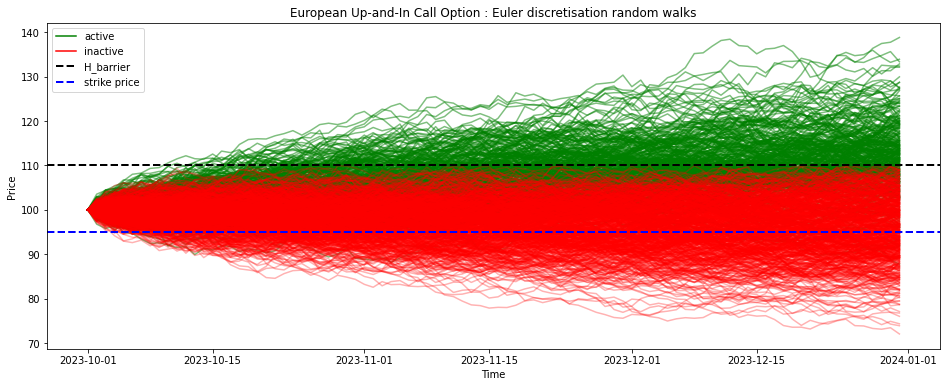

In [167]:
barrier_option.plot_barrier_paths()

In [230]:
barrier_type=1
print("Basic realisation paths")
results_df = generate_results(barrier_type, S_u, antithetic_variates=False)

Basic realisation paths


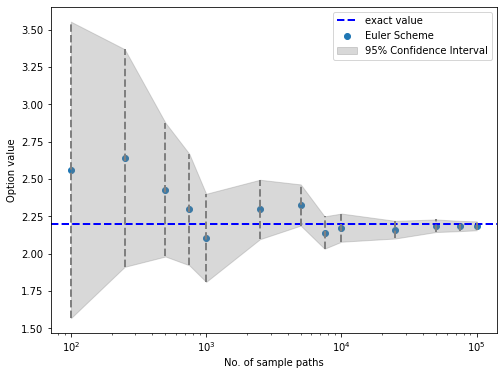

In [212]:
plot_confidence_interval(results_adf, 1, 2, 'Euler Scheme')

## 1. European Up-and-In Call Option

In [218]:
# Euler discretisation simulator
start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2)
barOpt_1 = BarrierOption(S0, K, r, sigma, T, N, M, T0, T2, ed_simulator, 1, S_u, S_d)
barOpt_1.run_monte_carlo(antithetic_variates=False)
(price_1, SE_1) = barOpt_1.get_Barrier_price()
end_time_1 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Euler discretisation": [round(price_1,4)],
        "Error": [round(SE_1,5)],
        "Time": [end_time_1],
    }
)
results

Euler discretisation    Error    Time
0                2.2705  0.15928  0.0185

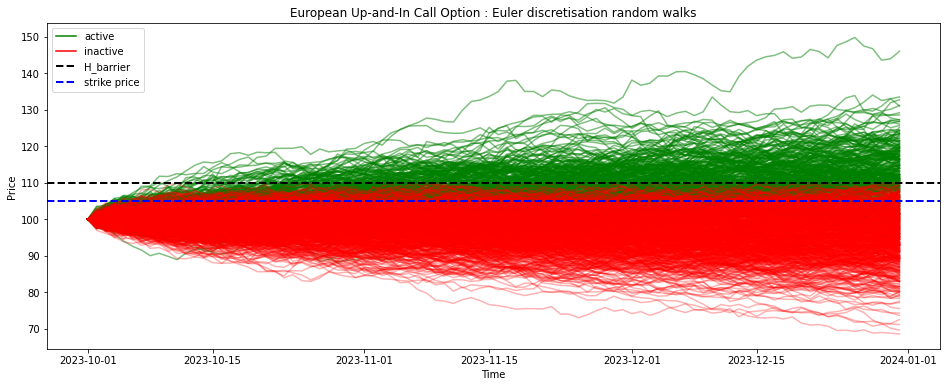

In [219]:
barOpt_1.plot_barrier_paths()

### model comparisons

In [260]:
up_in_call = up_and_in_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(up_in_call, 4)]}))

Exact value
0       7.1055

In [261]:
barrier_type=1
[result_1_1, result_1_2] = generate_results(barrier_type, S_u)
print("Basic realisation paths")
display(result_1_1)
print("Antithetic variate paths")
display(result_1_2)

Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        7.3361  1.17796  0.0068          7.3124  1.17361  0.0016   
1      250        8.0450  0.88356  0.0035          8.0445  0.88335  0.0012   
2      500        6.9126  0.56032  0.0081          6.9152  0.56018  0.0065   
3      750        7.5408  0.45783  0.0142          7.5512  0.45807  0.0040   
4     1000        7.7562  0.41264  0.0162          7.7626  0.41227  0.0057   
5     2500        6.8556  0.24776  0.0389          6.8512  0.24775  0.0146   
6     5000        7.2991  0.18025  0.1466          7.2972  0.18010  0.0317   
7     7500        7.0519  0.14458  0.4341          7.0512  0.14449  0.0503   
8    10000        7.2341  0.12742  0.1918          7.2336  0.12737  0.0825   
9    25000        7.0314  0.07930  0.5213          7.0310  0.07927  0.2310   
10   50000        7.1689  0.05640  0.9893          7.1685  0.05638  0.4349   
11   75000        7.1440  0.04570  1.2655          7.1441  0.04568  0.6715   
12  100000        7.0941  0.03938  1.6225          7.0940  0.03936  0.9272   

    Milstein  Error_3  Time_3  
0     7.3353  1.17784  0.0024  
1     8.0442  0.88347  0.0020  
2     6.9119  0.56026  0.0062  
3     7.5400  0.45778  0.0051  
4     7.7554  0.41260  0.0066  
5     6.8549  0.24774  0.0221  
6     7.2984  0.18023  0.0554  
7     7.0512  0.14457  0.0655  
8     7.2334  0.12740  0.0874  
9     7.0307  0.07929  0.2801  
10    7.1682  0.05640  0.6582  
11    7.1433  0.04569  0.9131  
12    7.0934  0.03938  1.3184

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        6.3359  0.64786  0.0026          6.3272  0.64573  0.0010   
1      250        7.6119  0.50358  0.0036          7.6092  0.50341  0.0023   
2      500        7.1962  0.33642  0.0104          7.1957  0.33611  0.0063   
3      750        7.1380  0.26230  0.0113          7.1430  0.26218  0.0078   
4     1000        7.2509  0.23101  0.0143          7.2554  0.23080  0.0100   
5     2500        6.9221  0.14252  0.0395          6.9193  0.14251  0.0264   
6     5000        7.1018  0.10341  0.0851          7.1003  0.10335  0.0554   
7     7500        7.1884  0.08518  0.1297          7.1876  0.08512  0.0956   
8    10000        7.1517  0.07375  0.1572          7.1512  0.07369  0.1109   
9    25000        7.0373  0.04645  0.3866          7.0369  0.04643  0.2722   
10   50000        7.1493  0.03268  1.3931          7.1482  0.03266  1.0032   
11   75000        7.1079  0.02666  2.3588          7.1079  0.02664  1.2882   
12  100000        7.0940  0.02297  2.9149          7.0935  0.02295  3.1759   

    Milstein  Error_3  Time_3  
0     6.3353  0.64781  0.0013  
1     7.6111  0.50353  0.0036  
2     7.1955  0.33639  0.0104  
3     7.1373  0.26227  0.0104  
4     7.2502  0.23099  0.0150  
5     6.9214  0.14250  0.0444  
6     7.1011  0.10340  0.0850  
7     7.1877  0.08517  0.1355  
8     7.1510  0.07375  0.1671  
9     7.0365  0.04645  0.5347  
10    7.1486  0.03268  2.1447  
11    7.1072  0.02666  4.0066  
12    7.0933  0.02296  4.6564

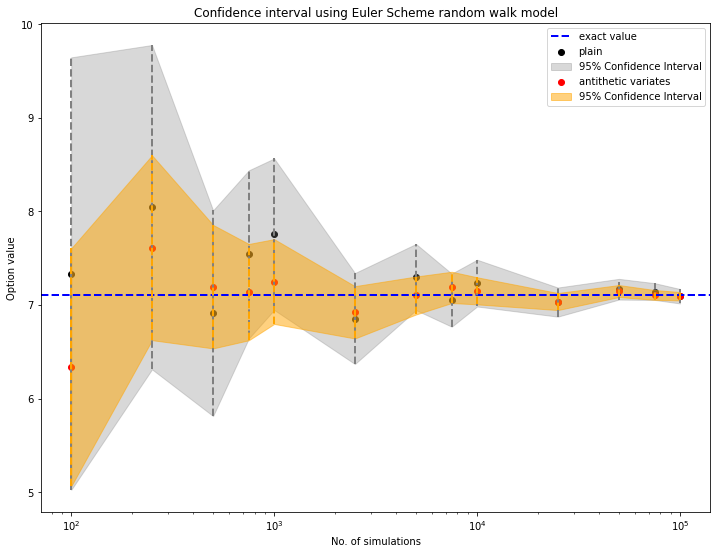

In [271]:
plot_confidence_interval(up_in_call, result_1_1, result_1_2, 1, 2, 'Euler Scheme')

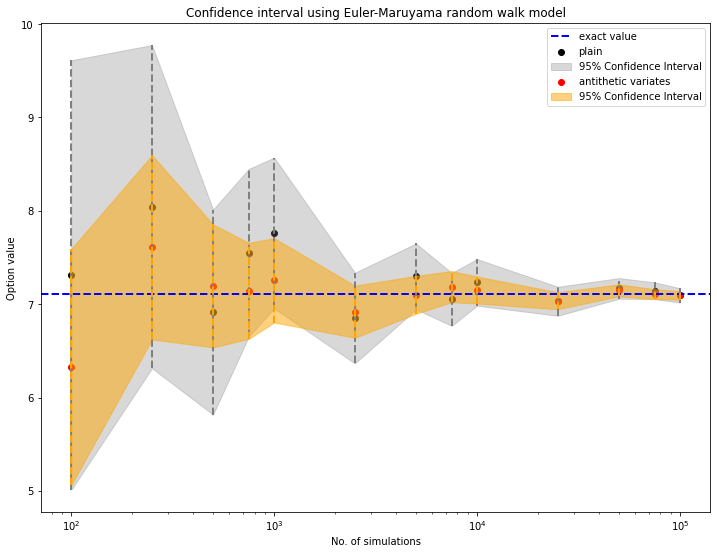

In [272]:
plot_confidence_interval(up_in_call, result_1_1, result_1_2, 4, 5, 'Euler-Maruyama')

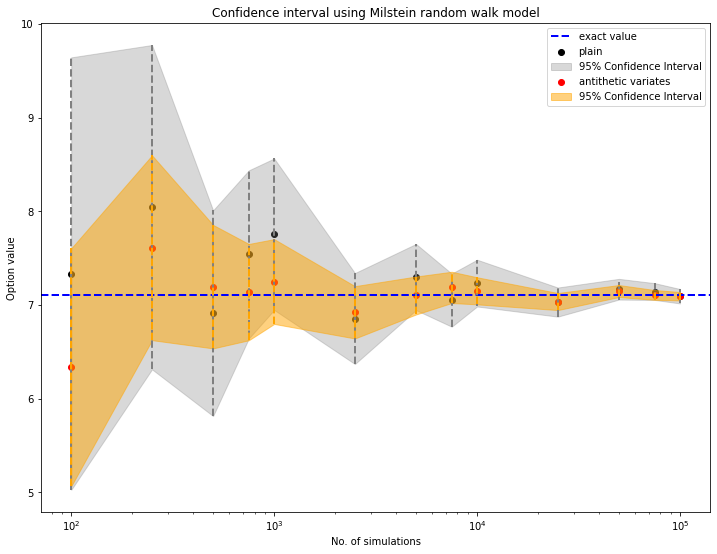

In [273]:
plot_confidence_interval(up_in_call, result_1_1, result_1_2, 7, 8, 'Milstein')

In [267]:
latex_code_1_1 = result_1_1.to_latex(index=False, escape=False)
print(latex_code_1_1)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        7.3361 &  1.17796 &  0.0068 &          7.3124 &  1.17361 &  0.0016 &    7.3353 &  1.17784 &  0.0024 \\
   250 &        8.0450 &  0.88356 &  0.0035 &          8.0445 &  0.88335 &  0.0012 &    8.0442 &  0.88347 &  0.0020 \\
   500 &        6.9126 &  0.56032 &  0.0081 &          6.9152 &  0.56018 &  0.0065 &    6.9119 &  0.56026 &  0.0062 \\
   750 &        7.5408 &  0.45783 &  0.0142 &          7.5512 &  0.45807 &  0.0040 &    7.5400 &  0.45778 &  0.0051 \\
  1000 &        7.7562 &  0.41264 &  0.0162 &          7.7626 &  0.41227 &  0.0057 &    7.7554 &  0.41260 &  0.0066 \\
  2500 &        6.8556 &  0.24776 &  0.0389 &          6.8512 &  0.24775 &  0.0146 &    6.8549 &  0.24774 &  0.0221 \\
  5000 &        7.2991 &  0.18025 &  0.1466 &          7.2972 &  0.18010 &  0.0317 &    7.2984 &  0.18023 &  0.0554 \\
  

In [268]:
latex_code_1_2 = result_1_2.to_latex(index=False, escape=False)
print(latex_code_1_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        6.3359 &  0.64786 &  0.0026 &          6.3272 &  0.64573 &  0.0010 &    6.3353 &  0.64781 &  0.0013 \\
   250 &        7.6119 &  0.50358 &  0.0036 &          7.6092 &  0.50341 &  0.0023 &    7.6111 &  0.50353 &  0.0036 \\
   500 &        7.1962 &  0.33642 &  0.0104 &          7.1957 &  0.33611 &  0.0063 &    7.1955 &  0.33639 &  0.0104 \\
   750 &        7.1380 &  0.26230 &  0.0113 &          7.1430 &  0.26218 &  0.0078 &    7.1373 &  0.26227 &  0.0104 \\
  1000 &        7.2509 &  0.23101 &  0.0143 &          7.2554 &  0.23080 &  0.0100 &    7.2502 &  0.23099 &  0.0150 \\
  2500 &        6.9221 &  0.14252 &  0.0395 &          6.9193 &  0.14251 &  0.0264 &    6.9214 &  0.14250 &  0.0444 \\
  5000 &        7.1018 &  0.10341 &  0.0851 &          7.1003 &  0.10335 &  0.0554 &    7.1011 &  0.10340 &  0.0850 \\
  

In [360]:
# Euler discretisation simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_1 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 1, S_u, S_d)
barOpt_1.run_monte_carlo(antithetic_variates=True)
(price_1, SE_1) = barOpt_1.get_Barrier_price()
end_time_1 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Euler discretisation": [round(price_1,4)],
        "Error": [round(SE_1,5)],
        "Time": [end_time_1],
    }
)
results

Euler discretisation    Error    Time
0                7.1624  1.68296  0.0077

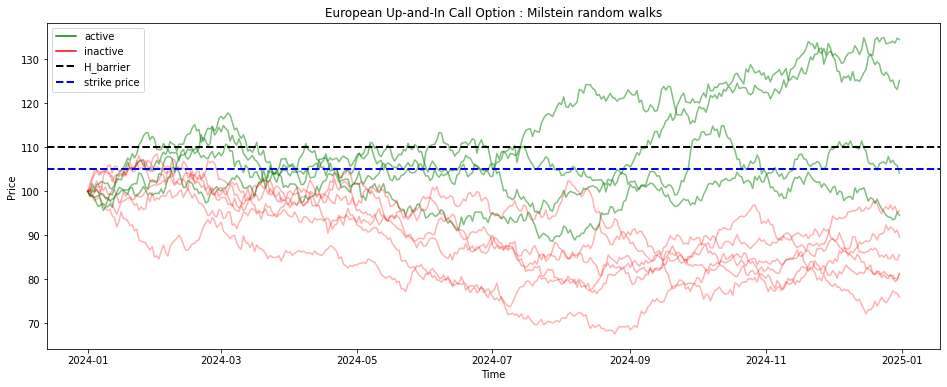

In [361]:
barOpt_1.plot_barrier_paths()

## 2. European Up-and-Out Call Option

In [362]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_2 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 2, S_u, S_d)
barOpt_2.run_monte_carlo(antithetic_variates=True)
(price_2, SE_2) = barOpt_2.get_Barrier_price()
end_time_2 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_2,4)],
        "Error": [round(SE_2,5)],
        "Time": [end_time_2],
    }
)
results

Milstein  Error   Time
0       0.0    0.0  0.001

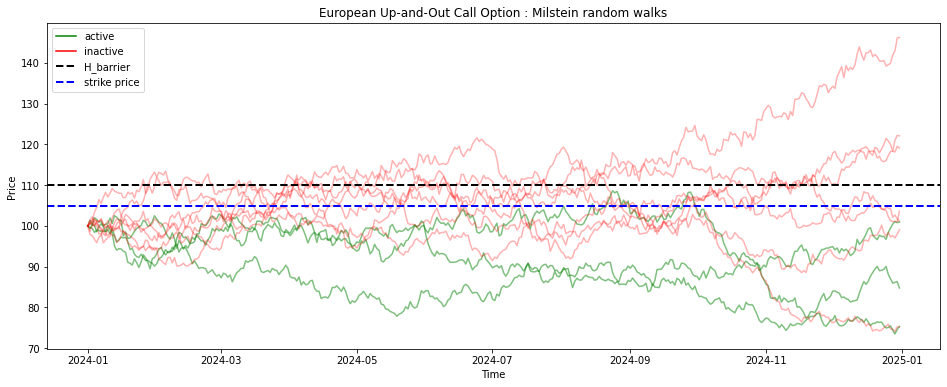

In [363]:
barOpt_2.plot_barrier_paths()

### model comparisons

In [136]:
up_out_call = up_and_out_call(S0, K, r, sigma, T, S_u_new)
display(pd.DataFrame({'Exact value': [round(up_out_call, 4)]}))

Exact value
0       0.1236

In [89]:
barrier_type=2
print("Basic realisation paths")
generate_results(barrier_type, S_u, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.1234  0.00564  0.0643          0.1246  0.00569   
1   20000                0.1195  0.00400  0.0712          0.1182  0.00398   
2   30000                0.1152  0.00317  0.1249          0.1145  0.00315   
3   40000                0.1193  0.00280  0.4267          0.1196  0.00280   
4   50000                0.1215  0.00252  0.1803          0.1224  0.00254   
5   60000                0.1194  0.00228  0.2452          0.1206  0.00230   
6   70000                0.1227  0.00217  0.2698          0.1232  0.00217   
7   80000                0.1175  0.00195  0.3091          0.1183  0.00196   
8   90000                0.1208  0.00188  0.3911          0.1210  0.00188   
9  100000                0.1217  0.00180  0.4221          0.1217  0.00179   

   Time_2  Milstein  Error_3  Time_3  
0  0.0165    0.1234  0.00564  0.0184  
1  0.0274    0.1195  0.00400  0.0347  
2  0.0489    0.1152  0.00317  0.0685  
3  0.0731    0.1193  0.00280  0.0649  
4  0.0747    0.1215  0.00252  0.0925  
5  0.0880    0.1194  0.00228  0.1187  
6  0.1139    0.1227  0.00217  0.1509  
7  0.1263    0.1176  0.00195  0.1823  
8  0.1318    0.1209  0.00188  0.1765  
9  0.1460    0.1217  0.00179  0.1960

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.1234 &  0.00564 &  0.0643 &          0.1246 &  0.00569 &  0.0165 &    0.1234 &  0.00564 &  0.0184 \\
 20000 &                0.1195 &  0.00400 &  0.0712 &          0.1182 &  0.00398 &  0.0274 &    0.1195 &  0.00400 &  0.0347 \\
 30000 &                0.1152 &  0.00317 &  0.1249 &          0.1145 &  0.00315 &  0.0489 &    0.1152 &  0.00317 &  0.0685 \\
 40000 &                0.1193 &  0.00280 &  0.4267 &          0.1196 &  0.00280 &  0.0731 &    0.1193 &  0.00280 &  0.0649 \\
 50000 &                0.1215 &  0.00252 &  0.1803 &          0.1224 &  0.00254 &  0.0747 &    0.1215 &  0.00252 &  0.0925 \\
 60000 &                0.1194 &  0.00228 &  0.2452 &          0.1206 &  0.00230 &  0.0880 &    0.1194 &  0.00228 &  0.1187 \\
 70000 &                0.1227 &  0.00217 &  0.2698 &          0.

In [90]:
barrier_type=2
print("Antithetic variate paths")
generate_results(barrier_type, S_u, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.1173  0.00379  0.0947          0.1178  0.00380   
1   20000                0.1214  0.00275  0.1310          0.1225  0.00277   
2   30000                0.1156  0.00220  0.2221          0.1157  0.00220   
3   40000                0.1189  0.00194  0.3414          0.1194  0.00195   
4   50000                0.1202  0.00173  0.3210          0.1207  0.00174   
5   60000                0.1201  0.00158  0.3810          0.1203  0.00158   
6   70000                0.1184  0.00146  0.4411          0.1183  0.00146   
7   80000                0.1209  0.00137  0.5157          0.1210  0.00138   
8   90000                0.1191  0.00129  0.5665          0.1195  0.00129   
9  100000                0.1195  0.00122  0.6387          0.1204  0.00123   

   Time_2  Milstein  Error_3  Time_3  
0  0.0290    0.1174  0.00379  0.0379  
1  0.0587    0.1214  0.00275  0.0728  
2  0.1009    0.1158  0.00220  0.1305  
3  0.1136    0.1190  0.00194  0.1552  
4  0.1561    0.1202  0.00173  0.2064  
5  0.1826    0.1201  0.00158  0.2449  
6  0.2150    0.1184  0.00146  0.2892  
7  0.2564    0.1209  0.00137  0.3391  
8  0.2681    0.1191  0.00129  0.4551  
9  0.3164    0.1196  0.00122  0.4997

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.1173 &  0.00379 &  0.0947 &          0.1178 &  0.00380 &  0.0290 &    0.1174 &  0.00379 &  0.0379 \\
 20000 &                0.1214 &  0.00275 &  0.1310 &          0.1225 &  0.00277 &  0.0587 &    0.1214 &  0.00275 &  0.0728 \\
 30000 &                0.1156 &  0.00220 &  0.2221 &          0.1157 &  0.00220 &  0.1009 &    0.1158 &  0.00220 &  0.1305 \\
 40000 &                0.1189 &  0.00194 &  0.3414 &          0.1194 &  0.00195 &  0.1136 &    0.1190 &  0.00194 &  0.1552 \\
 50000 &                0.1202 &  0.00173 &  0.3210 &          0.1207 &  0.00174 &  0.1561 &    0.1202 &  0.00173 &  0.2064 \\
 60000 &                0.1201 &  0.00158 &  0.3810 &          0.1203 &  0.00158 &  0.1826 &    0.1201 &  0.00158 &  0.2449 \\
 70000 &                0.1184 &  0.00146 &  0.4411 &          0.

## 3. European Down-and-In Call Option

In [364]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_3 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 3, S_u, S_d)
barOpt_3.run_monte_carlo(antithetic_variates=True)
(price_3, SE_3) = barOpt_3.get_Barrier_price()
end_time_3 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_3,4)],
        "Error": [round(SE_3,5)],
        "Time": [end_time_3],
    }
)
results

Milstein    Error    Time
0    2.9435  1.47008  0.0013

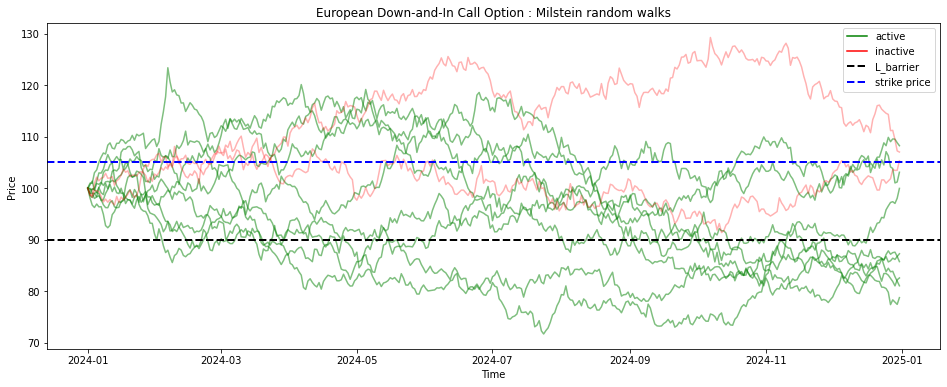

In [365]:
barOpt_3.plot_barrier_paths()

### model comparisons

In [137]:
down_in_call = down_and_in_call(S0, K, r, sigma, T, S_d_new)
display(pd.DataFrame({'Exact value': [round(down_in_call, 4)]}))

Exact value
0       0.0109

In [112]:
barrier_type=3
print("Basic realisation paths")
generate_results(barrier_type, S_d, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.0098  0.00238  0.0485          0.0097  0.00236   
1   20000                0.0096  0.00157  0.0700          0.0100  0.00159   
2   30000                0.0078  0.00102  0.1201          0.0079  0.00102   
3   40000                0.0130  0.00150  0.1717          0.0128  0.00149   
4   50000                0.0103  0.00112  0.2215          0.0100  0.00109   
5   60000                0.0105  0.00105  0.2331          0.0103  0.00104   
6   70000                0.0099  0.00093  0.3547          0.0099  0.00092   
7   80000                0.0105  0.00086  0.3395          0.0104  0.00085   
8   90000                0.0115  0.00097  0.3839          0.0114  0.00096   
9  100000                0.0109  0.00083  0.4340          0.0110  0.00083   

   Time_2  Milstein  Error_3  Time_3  
0  0.0177    0.0098  0.00238  0.0197  
1  0.0266    0.0096  0.00157  0.0349  
2  0.0505    0.0078  0.00102  0.0649  
3  0.0914    0.0130  0.00150  0.3288  
4  0.0875    0.0103  0.00112  0.1185  
5  0.1015    0.0105  0.00105  0.1633  
6  0.1128    0.0099  0.00093  0.1479  
7  0.1282    0.0105  0.00086  0.1781  
8  0.1371    0.0115  0.00097  0.2015  
9  0.1739    0.0109  0.00083  0.2462

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.0098 &  0.00238 &  0.0485 &          0.0097 &  0.00236 &  0.0177 &    0.0098 &  0.00238 &  0.0197 \\
 20000 &                0.0096 &  0.00157 &  0.0700 &          0.0100 &  0.00159 &  0.0266 &    0.0096 &  0.00157 &  0.0349 \\
 30000 &                0.0078 &  0.00102 &  0.1201 &          0.0079 &  0.00102 &  0.0505 &    0.0078 &  0.00102 &  0.0649 \\
 40000 &                0.0130 &  0.00150 &  0.1717 &          0.0128 &  0.00149 &  0.0914 &    0.0130 &  0.00150 &  0.3288 \\
 50000 &                0.0103 &  0.00112 &  0.2215 &          0.0100 &  0.00109 &  0.0875 &    0.0103 &  0.00112 &  0.1185 \\
 60000 &                0.0105 &  0.00105 &  0.2331 &          0.0103 &  0.00104 &  0.1015 &    0.0105 &  0.00105 &  0.1633 \\
 70000 &                0.0099 &  0.00093 &  0.3547 &          0.

In [113]:
barrier_type=3
print("Antithetic variate paths")
generate_results(barrier_type, S_d, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                0.0119  0.00188  0.1097          0.0118  0.00186   
1   20000                0.0108  0.00131  0.1212          0.0108  0.00131   
2   30000                0.0095  0.00096  0.2144          0.0097  0.00098   
3   40000                0.0093  0.00076  0.2515          0.0091  0.00075   
4   50000                0.0101  0.00080  0.3258          0.0101  0.00079   
5   60000                0.0111  0.00077  0.3851          0.0112  0.00077   
6   70000                0.0117  0.00073  0.4501          0.0116  0.00072   
7   80000                0.0112  0.00065  0.5183          0.0111  0.00064   
8   90000                0.0114  0.00062  0.6043          0.0112  0.00062   
9  100000                0.0108  0.00059  0.6836          0.0104  0.00057   

   Time_2  Milstein  Error_3  Time_3  
0  0.0311    0.0119  0.00188  0.0370  
1  0.0614    0.0108  0.00131  0.0809  
2  0.1138    0.0095  0.00096  0.1187  
3  0.1353    0.0093  0.00076  0.1791  
4  0.1571    0.0101  0.00080  0.2080  
5  0.1799    0.0111  0.00077  0.2438  
6  0.2143    0.0117  0.00073  0.2937  
7  0.2518    0.0112  0.00065  0.3411  
8  0.2752    0.0113  0.00062  0.3976  
9  0.3058    0.0108  0.00059  0.4071

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                0.0119 &  0.00188 &  0.1097 &          0.0118 &  0.00186 &  0.0311 &    0.0119 &  0.00188 &  0.0370 \\
 20000 &                0.0108 &  0.00131 &  0.1212 &          0.0108 &  0.00131 &  0.0614 &    0.0108 &  0.00131 &  0.0809 \\
 30000 &                0.0095 &  0.00096 &  0.2144 &          0.0097 &  0.00098 &  0.1138 &    0.0095 &  0.00096 &  0.1187 \\
 40000 &                0.0093 &  0.00076 &  0.2515 &          0.0091 &  0.00075 &  0.1353 &    0.0093 &  0.00076 &  0.1791 \\
 50000 &                0.0101 &  0.00080 &  0.3258 &          0.0101 &  0.00079 &  0.1571 &    0.0101 &  0.00080 &  0.2080 \\
 60000 &                0.0111 &  0.00077 &  0.3851 &          0.0112 &  0.00077 &  0.1799 &    0.0111 &  0.00077 &  0.2438 \\
 70000 &                0.0117 &  0.00073 &  0.4501 &          0.

## 4. European Down-and-Out Call Option

In [366]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_4 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 4, S_u, S_d)
barOpt_4.run_monte_carlo(antithetic_variates=True)
(price_4, SE_4) = barOpt_4.get_Barrier_price()
end_time_4 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_4,4)],
        "Error": [round(SE_4,5)],
        "Time": [end_time_4],
    }
)
results

Milstein    Error    Time
0    7.9546  2.55948  0.0021

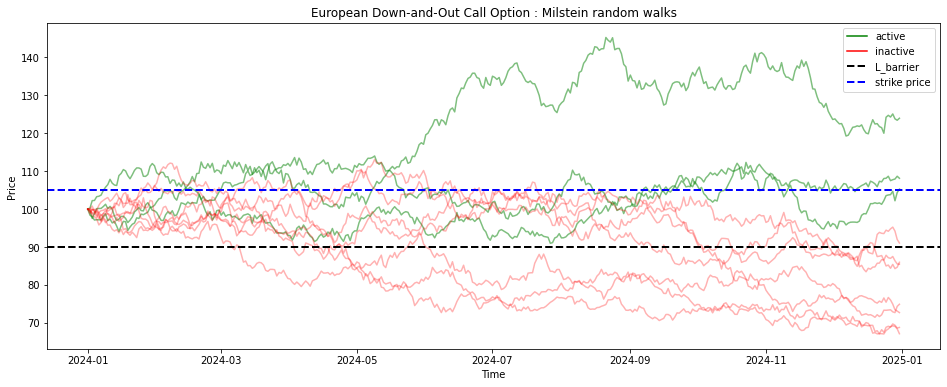

In [367]:
barOpt_4.plot_barrier_paths()

### model comparisons

In [138]:
down_out_call = down_and_out_call(S0, K, r, sigma, T, S_d_new)
display(pd.DataFrame({'Exact value': [round(down_out_call, 4)]}))

Exact value
0       2.2893

In [130]:
barrier_type=4
print("Basic realisation paths")
generate_results(barrier_type, S_d, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                2.2684  0.04733  0.0555          2.2678  0.04729   
1   20000                2.2338  0.03318  0.0808          2.2330  0.03315   
2   30000                2.2646  0.02760  0.1232          2.2640  0.02757   
3   40000                2.2992  0.02392  0.1876          2.2983  0.02390   
4   50000                2.2981  0.02132  0.2546          2.2970  0.02130   
5   60000                2.2962  0.01953  0.3292          2.2957  0.01951   
6   70000                2.2833  0.01799  0.3470          2.2826  0.01797   
7   80000                2.2751  0.01681  0.3517          2.2741  0.01680   
8   90000                2.2848  0.01602  0.4858          2.2837  0.01600   
9  100000                2.2812  0.01506  0.4605          2.2804  0.01505   

   Time_2  Milstein  Error_3  Time_3  
0  0.0155    2.2681  0.04732  0.0179  
1  0.0285    2.2335  0.03318  0.0359  
2  0.0454    2.2643  0.02759  0.0621  
3  0.0548    2.2991  0.02392  0.0732  
4  0.0668    2.2979  0.02132  0.1236  
5  0.0844    2.2959  0.01953  0.1125  
6  0.0930    2.2830  0.01798  0.1213  
7  0.1106    2.2747  0.01681  0.1465  
8  0.1265    2.2845  0.01602  0.1785  
9  0.1361    2.2809  0.01506  0.2604

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                2.2684 &  0.04733 &  0.0555 &          2.2678 &  0.04729 &  0.0155 &    2.2681 &  0.04732 &  0.0179 \\
 20000 &                2.2338 &  0.03318 &  0.0808 &          2.2330 &  0.03315 &  0.0285 &    2.2335 &  0.03318 &  0.0359 \\
 30000 &                2.2646 &  0.02760 &  0.1232 &          2.2640 &  0.02757 &  0.0454 &    2.2643 &  0.02759 &  0.0621 \\
 40000 &                2.2992 &  0.02392 &  0.1876 &          2.2983 &  0.02390 &  0.0548 &    2.2991 &  0.02392 &  0.0732 \\
 50000 &                2.2981 &  0.02132 &  0.2546 &          2.2970 &  0.02130 &  0.0668 &    2.2979 &  0.02132 &  0.1236 \\
 60000 &                2.2962 &  0.01953 &  0.3292 &          2.2957 &  0.01951 &  0.0844 &    2.2959 &  0.01953 &  0.1125 \\
 70000 &                2.2833 &  0.01799 &  0.3470 &          2.

In [131]:
barrier_type=4
print("Antithetic variate paths")
generate_results(barrier_type, S_d, antithetic_variates=True)

Antithetic variate paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000                2.3138  0.02971  0.1048          2.3128  0.02969   
1   20000                2.2784  0.02101  0.1154          2.2775  0.02099   
2   30000                2.2784  0.01704  0.1637          2.2775  0.01701   
3   40000                2.3021  0.01489  0.2175          2.3013  0.01487   
4   50000                2.2861  0.01320  0.2869          2.2853  0.01318   
5   60000                2.2634  0.01200  0.4596          2.2627  0.01199   
6   70000                2.3022  0.01121  0.5094          2.3012  0.01119   
7   80000                2.3004  0.01055  0.5080          2.2994  0.01054   
8   90000                2.2995  0.00993  0.5847          2.2988  0.00992   
9  100000                2.2827  0.00936  0.6604          2.2818  0.00935   

   Time_2  Milstein  Error_3  Time_3  
0  0.0282    2.3135  0.02971  0.0373  
1  0.0495    2.2781  0.02101  0.0656  
2  0.0760    2.2781  0.01703  0.1048  
3  0.1009    2.3018  0.01489  0.1359  
4  0.2596    2.2858  0.01320  0.2872  
5  0.2081    2.2631  0.01200  0.2963  
6  0.1953    2.3019  0.01121  0.2868  
7  0.2560    2.3001  0.01055  0.3647  
8  0.2780    2.2993  0.00993  0.4037  
9  0.3380    2.2824  0.00936  0.4846

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &                2.3138 &  0.02971 &  0.1048 &          2.3128 &  0.02969 &  0.0282 &    2.3135 &  0.02971 &  0.0373 \\
 20000 &                2.2784 &  0.02101 &  0.1154 &          2.2775 &  0.02099 &  0.0495 &    2.2781 &  0.02101 &  0.0656 \\
 30000 &                2.2784 &  0.01704 &  0.1637 &          2.2775 &  0.01701 &  0.0760 &    2.2781 &  0.01703 &  0.1048 \\
 40000 &                2.3021 &  0.01489 &  0.2175 &          2.3013 &  0.01487 &  0.1009 &    2.3018 &  0.01489 &  0.1359 \\
 50000 &                2.2861 &  0.01320 &  0.2869 &          2.2853 &  0.01318 &  0.2596 &    2.2858 &  0.01320 &  0.2872 \\
 60000 &                2.2634 &  0.01200 &  0.4596 &          2.2627 &  0.01199 &  0.2081 &    2.2631 &  0.01200 &  0.2963 \\
 70000 &                2.3022 &  0.01121 &  0.5094 &          2.

## 5. European Up-and-In Put Option

In [368]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_5 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 5, S_u, S_d)
barOpt_5.run_monte_carlo(antithetic_variates=True)
(price_5, SE_5) = barOpt_5.get_Barrier_price()
end_time_5 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_5,4)],
        "Error": [round(SE_5,5)],
        "Time": [end_time_5],
    }
)
results

Milstein    Error    Time
0   42.2059  6.06544  0.0016

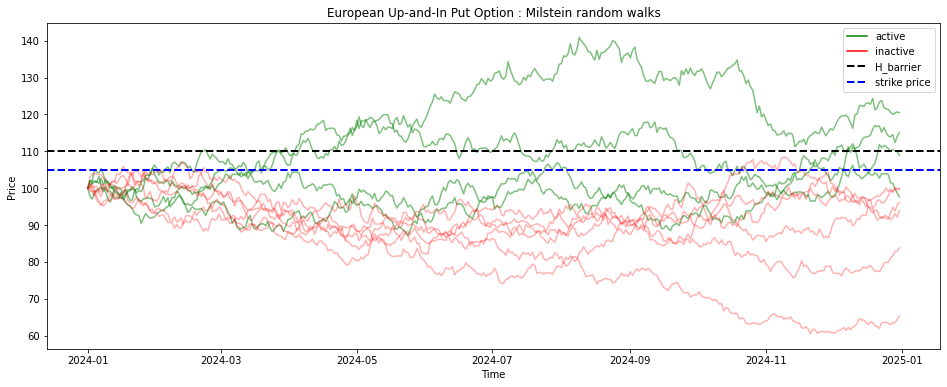

In [369]:
barOpt_5.plot_barrier_paths()

### model comparisons

In [152]:
up_in_put = up_and_in_put(S0, K, r, sigma, T, S_d_new)
display(pd.DataFrame({'Exact value': [round(up_in_put, 4)]}))

Exact value
0      25.5209

## 6. European Up-and-Out Put Option

In [370]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_6 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 6, S_u, S_d)
barOpt_6.run_monte_carlo(antithetic_variates=True)
(price_6, SE_6) = barOpt_6.get_Barrier_price()
end_time_6 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_6,4)],
        "Error": [round(SE_6,5)],
        "Time": [end_time_6],
    }
)
results

Milstein   Error    Time
0   70.7739  6.8377  0.0012

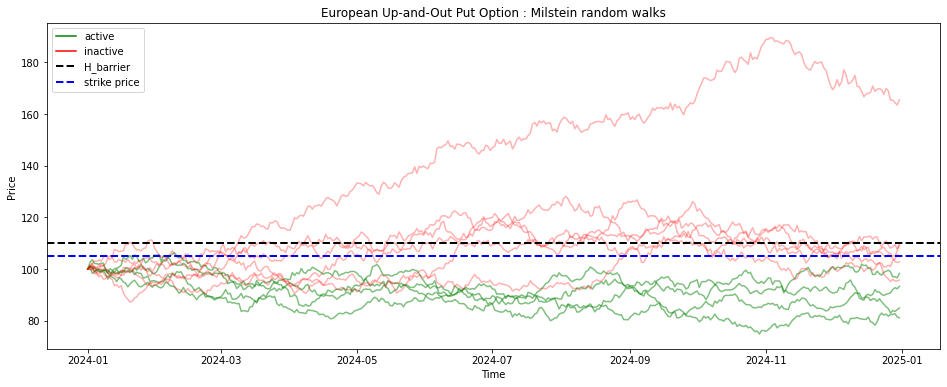

In [372]:
barOpt_6.plot_barrier_paths()

## 7. European Down-and-In Put Option

In [373]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_7 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 7, S_u, S_d)
barOpt_7.run_monte_carlo(antithetic_variates=True)
(price_7, SE_7) = barOpt_7.get_Barrier_price()
end_time_7 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_7,4)],
        "Error": [round(SE_7,5)],
        "Time": [end_time_7],
    }
)
results

Milstein     Error    Time
0   40.5727  10.76524  0.0021

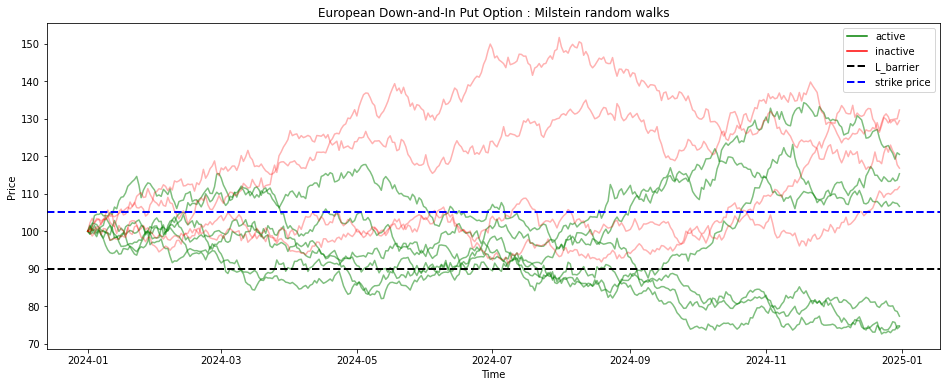

In [374]:
barOpt_7.plot_barrier_paths()

## 8. European Down-and-Out Put Option

In [375]:
# Milstein simulator
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, 10, T0, T2)
barOpt_8 = BarrierOption(S0, K, r, sigma, T, N, 10, T0, T2, mil_simulator, 8, S_u, S_d)
barOpt_8.run_monte_carlo(antithetic_variates=True)
(price_8, SE_8) = barOpt_8.get_Barrier_price()
end_time_8 = round(time.time() - start_time,4)

results = pd.DataFrame(
    {
        "Milstein": [round(price_8,4)],
        "Error": [round(SE_8,5)],
        "Time": [end_time_8],
    }
)
results

Milstein    Error    Time
0   66.4835  7.73167  0.0027

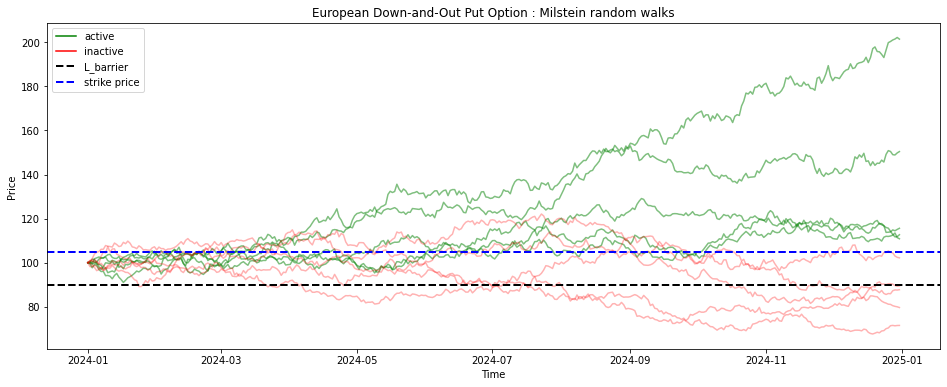

In [376]:
barOpt_8.plot_barrier_paths()

In [165]:
# down_out_put = down_and_out_put(50, 50, 0.1, 0.2, 1, 40)
# display(pd.DataFrame({'Exact value': [round(down_out_put, 4)]}))

down_out_put = down_and_out_put(S0, K, r, sigma, T, S_d_new)
display(pd.DataFrame({'Exact value': [round(down_out_put, 4)]}))

Exact value
0       2.6168

In [164]:
barrier_type=8
print("Basic realisation paths")
generate_results(barrier_type, S_d, antithetic_variates=False)

Basic realisation paths


n  Euler discretisation  Error_1  Time_1  Euler-Maruyama  Error_2  \
0   10000               29.3700  0.44169  0.1267         29.3570  0.44165   
1   20000               29.5421  0.31265  0.1005         29.5602  0.31274   
2   30000               29.4747  0.25515  0.1549         29.4449  0.25505   
3   40000               29.5449  0.22130  0.3784         29.5318  0.22127   
4   50000               29.7182  0.19831  0.1953         29.7560  0.19842   
5   60000               29.7246  0.18103  0.3360         29.6960  0.18097   
6   70000               29.4107  0.16688  0.4584         29.4133  0.16690   
7   80000               29.5028  0.15632  0.4936         29.4755  0.15627   
8   90000               29.1456  0.14669  0.6383         29.1438  0.14670   
9  100000               29.3282  0.13954  0.5706         29.3088  0.13951   

   Time_2  Milstein  Error_3  Time_3  
0  0.0540   29.3605  0.44163  0.0275  
1  0.0285   29.5372  0.31263  0.0365  
2  0.0467   29.4715  0.25513  0.0597  
3  0.0510   29.5425  0.22129  0.1873  
4  0.0747   29.7142  0.19830  0.0988  
5  0.1102   29.7182  0.18102  0.1480  
6  0.1038   29.4065  0.16687  0.1379  
7  0.1250   29.5015  0.15632  0.1645  
8  0.1363   29.1413  0.14668  0.1731  
9  0.1592   29.3224  0.13953  0.3363

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler discretisation &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
 10000 &               29.3700 &  0.44169 &  0.1267 &         29.3570 &  0.44165 &  0.0540 &   29.3605 &  0.44163 &  0.0275 \\
 20000 &               29.5421 &  0.31265 &  0.1005 &         29.5602 &  0.31274 &  0.0285 &   29.5372 &  0.31263 &  0.0365 \\
 30000 &               29.4747 &  0.25515 &  0.1549 &         29.4449 &  0.25505 &  0.0467 &   29.4715 &  0.25513 &  0.0597 \\
 40000 &               29.5449 &  0.22130 &  0.3784 &         29.5318 &  0.22127 &  0.0510 &   29.5425 &  0.22129 &  0.1873 \\
 50000 &               29.7182 &  0.19831 &  0.1953 &         29.7560 &  0.19842 &  0.0747 &   29.7142 &  0.19830 &  0.0988 \\
 60000 &               29.7246 &  0.18103 &  0.3360 &         29.6960 &  0.18097 &  0.1102 &   29.7182 &  0.18102 &  0.1480 \\
 70000 &               29.4107 &  0.16688 &  0.4584 &         29.

# Asian Option

In [389]:
# Params
S0 = 100   # initial price
K = 105      # strike price
r = 0.03     # risk-free interest rate
sigma = 0.2 # voatility
# T1 = date(2024,12,1)  # start date of asian option average
T1 = date(2024,1,1)
T0 = date(2024,1,1)
T2 = date(2024,12,31) # maturity date
# T2 = T0 + timedelta(days=5)
T = ((T2-T0).days)/365 # time to maturity in years
N = (T2-T0).days # number of time steps
print(N)
dt = T/N     # time step size
print(dt)

365
0.0027397260273972603


In [379]:
class AsianOption(MC_simulator_optimised):
    def __init__(self, S0, K, r, sigma, T, N, M, T0, T2, T1, simulator):
        super().__init__(S0, K, r, sigma, T, N, M, T0, T2, simulator)
        self.T1 = T1 # start date of average price period
        self.em_mask = None # mask for Euler-Maruyama
        self.m_mask = None  # mask for Milstein
        self.title = 'European Asian'
        self.main_type = "Call"
        self.asian_price = None
        self.avg_prices = None
        self.asian_payoffs = None
    
    def arithmetic_avg(self, realisations):
        return np.mean(realisations, axis=0)
    
    def geometric_avg(self, realisations):
        return np.exp(np.mean(np.log(realisations), axis=0))
    
    def calculate_average_strike(self, start_point, option_type, avg_type):        
        rls = self.simulator.realisations[-start_point:, :]
        avg_prices = self.arithmetic_avg(rls) if (avg_type=="arithmetic") else self.geometric_avg(rls)
        S_expiry = self.simulator.realisations[-1,:]
        
        payoffs = (S_expiry - avg_prices) if (option_type=="c") else (avg_prices - S_expiry)
        payoffs = maximum(payoffs, 0)
                
        if (self.antithetic_variates):
            rls_2 = self.simulator.av_realisations[-start_point:, :]
            avg_prices_2 = self.arithmetic_avg(rls_2) if (avg_type=="arithmetic") else self.geometric_avg(rls_2)
            S_expiry_2 = self.simulator.av_realisations[-1,:]
            
            payoffs_2 = (S_expiry_2 - avg_prices_2) if (option_type=="c") else (avg_prices_2 - S_expiry_2)
            payoffs_2 = maximum(payoffs_2, 0)
            av_payoffs = 0.5 * (payoffs + payoffs_2)
            option_price = np.exp(-self.r*self.T) * np.sum(av_payoffs)/self.M
            self.asian_payoffs = av_payoffs
            return option_price
        else:
            option_price = exp(-self.r*self.T) * np.sum(payoffs)/self.M
            self.asian_payoffs = payoffs
            return option_price

    def calculate_average_rate(self, start_point, option_type, avg_type):        
        rls = self.simulator.realisations[-start_point:, :]
        avg_prices = self.arithmetic_avg(rls) if (avg_type=="arithmetic") else self.geometric_avg(rls)

        payoffs = (avg_prices - self.K) if (option_type=="c") else (self.K - avg_prices)
        payoffs = maximum(payoffs, 0)
                
        if (self.antithetic_variates):
            rls_2 = self.simulator.av_realisations[-start_point:, :]
            avg_prices_2 = self.arithmetic_avg(rls_2) if (avg_type=="arithmetic") else self.geometric_avg(rls_2)
            payoffs_2 = (avg_prices_2 - self.K) if (option_type=="c") else (self.K - avg_prices_2)
            payoffs_2 = maximum(payoffs_2, 0)
            av_payoffs = 0.5 * (payoffs + payoffs_2)
            option_price = np.exp(-self.r*self.T) * np.sum(av_payoffs)/self.M
            self.asian_payoffs = av_payoffs
            return option_price
        else:
            option_price = exp(-self.r*self.T) * np.sum(payoffs)/self.M
            self.asian_payoffs = payoffs
            return option_price
    
    def get_average_rate_Asian_price(self, option_type, avg_type):
        self.main_type = "Call" if option_type=='c' else "Put"
        self.title = self.title + ' ' + self.main_type + " option"
        
        start_point = (self.T1 - self.T0).days -1 # starting date of time period for calculating average
        self.asian_price = self.calculate_average_rate(start_point, option_type, avg_type)
        SE = self.standard_error(self.asian_payoffs, self.asian_price)
        return (self.asian_price, SE)
    
    def get_average_strike_Asian_price(self, option_type, avg_type):
        self.main_type = "Call" if option_type=='c' else "Put"
        self.title = self.title + ' ' + self.main_type + " option"
        
        start_point = (self.T1 - self.T0).days -1 # starting date of time period for calculating average
        self.asian_price = self.calculate_average_strike(start_point, option_type, avg_type)
        SE = self.standard_error(self.asian_payoffs, self.asian_price)
        return (self.asian_price, SE)
    
    def plot_asian_paths(self):
        plt.figure(figsize=(16, 6))
        random_walk = self.simulator.av_realisations if self.antithetic_variates else self.simulator.realisations

        # plot realisations
        timeline = pd.date_range(start=self.T0,end=self.T2)
        plt.plot(timeline, random_walk)
        
        # highlight average price of region
        plt.axvspan(self.T1, self.T2, color="cyan", alpha=0.5)
        plt.axvline(x=self.T1, color="orange", linestyle='-', linewidth=5, label='$T_1$')
        plt.axvline(x=self.T2, color="red", linestyle='-', linewidth=5, label='$T_2$')

        # plot strike price
        plt.axhline(y=self.K, linestyle='--', color='blue',linewidth=2.0, label='strike price')

        plt.xlabel('Time')
        plt.ylabel('Price')
        _title = self.title + " : " + self.simulator.model_name + " random walks"
        plt.title(_title)
        plt.legend()
        plt.show()

Below are function to help with the testing of the Asian option pricing

In [398]:
def N_(x):
    # Define the standard normal distribution
    mean = 0
    std_dev = 1
    standard_normal = norm(loc=mean, scale=std_dev)
    return standard_normal.cdf(x)

def geometric_avg_call_option(S0, K, r, sigma, T):
    b = 0.5*(r- (sigma**2)/6)
    corrected_sigma = sigma/np.sqrt(3)
    d1 = (np.log(S0 / K) + (b + 0.5 * corrected_sigma**2) * T) / (corrected_sigma * np.sqrt(T))
    d2 = d1 - corrected_sigma * np.sqrt(T)
    
    # Calculate option price using the closed-form formula
    return S0 * np.exp((b-r) * T) * N_(d1) - K * np.exp(-r * T) * N_(d2)

def geometric_avg_put_option(S0, K, r, sigma, T):
    b = 0.5*(r- (sigma**2)/6)
    corrected_sigma = sigma/np.sqrt(3)
    d1 = (np.log(S0 / K) + (b + 0.5 * corrected_sigma**2) * T) / (corrected_sigma * np.sqrt(T))
    d2 = d1 - corrected_sigma * np.sqrt(T)
    
    # Calculate option price using the closed-form formula
    return (-S0) * np.exp((b-r) * T) * N_(-d1) + K * np.exp(-r * T) * N_(-d2)

def asian_test(M, asian_type, antithetic_variates, avg_type, put_call, phis):
    asian_types = {
        "average_rate": "get_average_rate_Asian_price",
        "average_strike": "get_average_strike_Asian_price"
    }
    
    selected = asian_types[asian_type]
        
    # Euler discretisation simulator
    start_time = time.time()
    ed_simulator = Euler_discretisation_fast_simulator("Euler Scheme", S0, K, r, sigma, T, N, M, T0, T2, phis)
    asian_1 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, ed_simulator)
    asian_1.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_1, SE_1) = asian_1.__getattribute__(selected)(put_call, avg_type)
    end_time_1 = round(time.time() - start_time,4)
    
    # Euler-Maruyama simulator
    start_time = time.time()
    em_simulator = Euler_Maruyama_fast_simulator("Euler-Maruyama", S0, K, r, sigma, T, N, M, T0, T2, phis)
    asian_2 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, em_simulator)
    asian_2.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_2, SE_2) = asian_2.__getattribute__(selected)(put_call, avg_type)
    end_time_2 = round(time.time() - start_time,4)
    
    # Milstein simulator
    start_time = time.time()
    mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
    asian_3 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, mil_simulator)
    asian_3.run_monte_carlo(antithetic_variates=antithetic_variates)
    (price_3, SE_3) = asian_3.__getattribute__(selected)(put_call, avg_type)
    end_time_3 = round(time.time() - start_time,4)
    
    results = pd.DataFrame(
        {
            'n': [M],
            "Euler Scheme": [round(price_1,4)],
            "Error_1": [round(SE_1,5)],
            "Time_1": [end_time_1],
            "Euler-Maruyama": [round(price_2,4)],
            "Error_2": [round(SE_2,5)],
            "Time_2": [end_time_2],
            "Milstein": [round(price_3,4)],
            "Error_3": [round(SE_3,5)],
            "Time_3": [end_time_3]
        }
    )
    return results

def generate_Asian_results(put_call, asian_type, avg_type):
    Ms = [100, 250, 500, 750, 1000, 2500, 5000, 7500, 10000, 25000, 50000, 75000, 100000]
    
    plain_results = []
    av_results = []
    for M in tqdm(Ms):
        # initialise random variables
        phis = np.random.normal(0, 1, size=(N,M))
        plain_results.append(asian_test(M, asian_type, False, avg_type, put_call, phis))
        av_results.append(asian_test(M, asian_type, True, avg_type, put_call, phis))
    combined_plain = pd.concat(plain_results, axis=0, ignore_index=True)
    combined_av = pd.concat(av_results, axis=0, ignore_index=True)

    return [combined_plain, combined_av]


def plot_Asian_confidence_interval(df_plain, df_av, val, se, name, exact_val=0, vanilla_val=0):
    plt.figure(figsize=(12, 9))
    
    x = df_plain.iloc[:, 0].values
    values_1 = df_plain.iloc[:, val].values
    SE_1 = df_plain.iloc[:, se].values
    SE_L_1 = values_1 + SE_1*(-1.96)
    SE_H_1 = values_1 + SE_1*(1.96)

    plt.scatter(x, values_1, color='k', label="plain")
    plt.fill_between(x, SE_L_1, SE_H_1, alpha=0.3, color='gray', label='95% Confidence Interval')
    plt.vlines(x=x, ymin=SE_L_1, ymax=SE_H_1, color='gray', linestyle='--', linewidth=2)
    
    if (exact_val > 0):
        plt.axhline(y=exact_val, color='b', linestyle='--', linewidth=2.0, label='exact value')
    
    if (vanilla_val > 0):
        plt.axhline(y=vanilla_val, color='green', linestyle='--', linewidth=2.0, label='vanilla value')

    values_2 = df_av.iloc[:, val].values
    SE_2 = df_av.iloc[:, se].values
    SE_L_2 = values_2 + SE_2*(-1.96)
    SE_H_2 = values_2 + SE_2*(1.96)
    
    plt.scatter(x, values_2, color='r', label="antithetic variates")
    plt.fill_between(x, SE_L_2, SE_H_2, alpha=0.5, color='orange', label='95% Confidence Interval')
    plt.vlines(x=x, ymin=SE_L_2, ymax=SE_H_2, color='orange', linestyle='--', linewidth=2)

    plt.xscale('log')
    plt.xlabel('No. of simulations')
    plt.ylabel('Option value')
    plt.title("Confidence interval using " + name + " random walk model")
    plt.legend()
    plt.show()

### Experiment

In [383]:
phis = np.random.normal(0, 1, size=(N,M))

start_time = time.time()
ed_simulator = Euler_discretisation_fast_simulator("Euler discretisation", S0, K, r, sigma, T, N, M, T0, T2, phis)


asian_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, ed_simulator)
asian_option.run_monte_carlo(antithetic_variates=True)
(option_price, SE) = asian_option.get_European_option_price('c')
# (asian_price, SE_1) = asian_option.get_average_rate_Asian_price('c', "arithmetic")
# (asian_price_2, SE_2) = asian_option.get_average_strike_Asian_price('c', "arithmetic")
(asian_pric_3, SE_3) = asian_option.get_average_rate_Asian_price('c', "geometric")
# (asian_price_4, SE_4) = asian_option.get_average_strike_Asian_price('c', "geometric")
print("Vanilla Call: value is {0} with standard error {1}".format(round(option_price,4), round(SE,3)))
# print("Arithmetic average rate Call: value is {0} with standard error {1}".format(round(asian_price,4), round(SE_1,3)))
# print("Arithmetic average strike Call: value is {0} with standard error {1}".format(round(asian_price_2,4), round(SE_2,3)))
print("Geometric average rate Call: value is {0} with standard error {1}".format(round(asian_pric_3,4), round(SE_3,3)))
# print("Geometric average strike Call: value is {0} with standard error {1}".format(round(asian_price_4,4), round(SE_4,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Vanilla Call: value is 7.1456 with standard error 0.23
Geometric average rate Call: value is 3.0269 with standard error 0.111
Computation time is:  0.0579


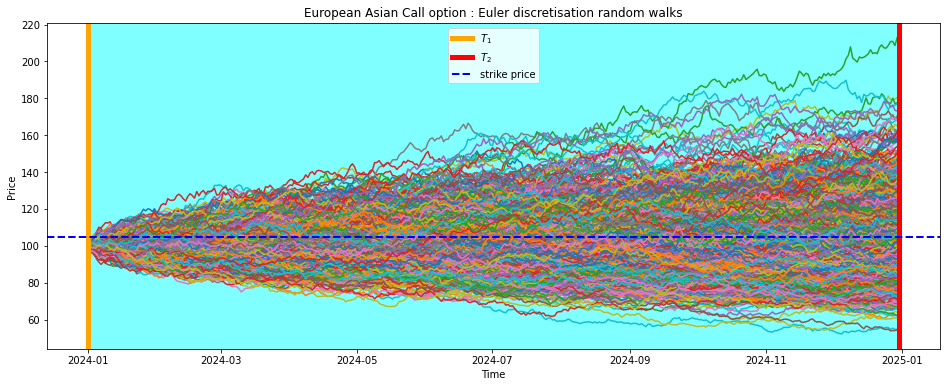

In [384]:
asian_option.plot_asian_paths()

### European average rate Asian Call Option - Average price of full length of contract

In [337]:
T1 = date(2024,1,1)
gac = geometric_avg_call_option(S0, K, r, sigma, T)
display(pd.DataFrame({'Exact value': [round(gac, 4)]}))

Exact value
0       2.9849

In [390]:
euro_call = european_call_option_price(S0, K, r, sigma, T)
display(pd.DataFrame({'European Call': [round(euro_call, 4)]}))

European Call
0         7.1281

In [315]:
[result_test_1, result_test_2] = generate_Asian_results('c', "average_rate", "arithmetic")
print("Basic realisation paths")
display(result_test_1)
print("Antithetic variate paths")
display(result_test_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        4.5168  0.79325  0.0019          4.5204  0.79367  0.0004   
1      250        3.1810  0.40401  0.0046          3.1833  0.40343  0.0010   
2      500        3.4042  0.29479  0.0192          3.4057  0.29452  0.0066   
3      750        3.1986  0.21974  0.0138          3.1970  0.21960  0.0039   
4     1000        3.1191  0.19165  0.0150          3.1187  0.19146  0.0050   
5     2500        3.2534  0.12519  0.0402          3.2540  0.12515  0.0137   
6     5000        3.0704  0.08473  0.1164          3.0685  0.08466  0.0310   
7     7500        3.3548  0.07325  0.1372          3.3538  0.07320  0.0550   
8    10000        3.2167  0.06206  0.1891          3.2161  0.06202  0.0874   
9    25000        3.1153  0.03825  0.6340          3.1146  0.03822  0.1728   
10   50000        3.1156  0.02717  0.9428          3.1150  0.02715  0.4343   
11   75000        3.1597  0.02232  1.0832          3.1591  0.02231  0.6053   
12  100000        3.1824  0.01947  1.6604          3.1818  0.01946  0.9503   

    Milstein  Error_3  Time_3  
0     4.5164  0.79316  0.0008  
1     3.1806  0.40397  0.0017  
2     3.4037  0.29475  0.0090  
3     3.1982  0.21972  0.0044  
4     3.1187  0.19163  0.0057  
5     3.2530  0.12517  0.0182  
6     3.0700  0.08472  0.0489  
7     3.3544  0.07324  0.0713  
8     3.2163  0.06206  0.1778  
9     3.1149  0.03825  0.2561  
10    3.1152  0.02717  0.7250  
11    3.1593  0.02232  0.7858  
12    3.1820  0.01947  1.2196

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        3.6151  0.40470  0.0025          3.6197  0.40492  0.0030   
1      250        3.2227  0.24727  0.0066          3.2224  0.24685  0.0031   
2      500        3.1832  0.17949  0.0135          3.1824  0.17923  0.0053   
3      750        3.0086  0.13077  0.0102          3.0064  0.13065  0.0064   
4     1000        3.1862  0.11481  0.0128          3.1858  0.11469  0.0081   
5     2500        3.1491  0.07439  0.0356          3.1494  0.07434  0.0247   
6     5000        3.1262  0.05229  0.0841          3.1250  0.05225  0.0547   
7     7500        3.2647  0.04319  0.1237          3.2641  0.04316  0.0903   
8    10000        3.1423  0.03663  0.1636          3.1423  0.03660  0.1047   
9    25000        3.1231  0.02329  0.4079          3.1223  0.02326  0.3136   
10   50000        3.1517  0.01659  1.8356          3.1511  0.01658  0.9690   
11   75000        3.1666  0.01358  1.9688          3.1658  0.01356  1.2144   
12  100000        3.1810  0.01180  3.0556          3.1803  0.01179  2.0547   

    Milstein  Error_3  Time_3  
0     3.6147  0.40466  0.0021  
1     3.2222  0.24724  0.0040  
2     3.1828  0.17947  0.0088  
3     3.0082  0.13076  0.0107  
4     3.1858  0.11480  0.0120  
5     3.1488  0.07438  0.0617  
6     3.1258  0.05229  0.1144  
7     3.2643  0.04319  0.1574  
8     3.1419  0.03663  0.1767  
9     3.1228  0.02328  0.5632  
10    3.1513  0.01659  2.3206  
11    3.1662  0.01357  4.6366  
12    3.1806  0.01179  5.9959

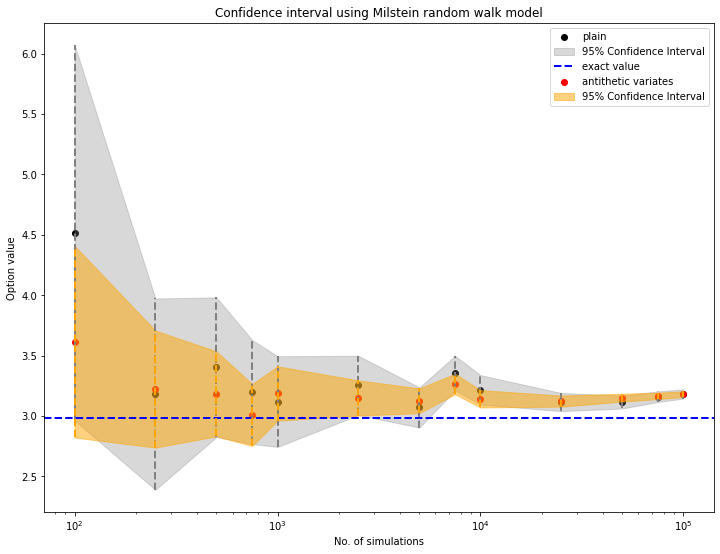

In [328]:
plot_Asian_confidence_interval(result_test_1, result_test_2, 7, 8, 'Milstein', gac)

In [327]:
[result_test_1_2, result_test_2_2] = generate_Asian_results('c', "average_rate", "geometric")
print("Basic realisation paths")
display(result_test_1_2)
print("Antithetic variate paths")
display(result_test_2_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        2.1525  0.47836  0.0035          2.1531  0.47860  0.0014   
1      250        2.7379  0.34885  0.0053          2.7322  0.34837  0.0017   
2      500        3.1371  0.27773  0.0119          3.1342  0.27763  0.0064   
3      750        2.8139  0.20103  0.0135          2.8122  0.20080  0.0071   
4     1000        2.8906  0.17842  0.0166          2.8903  0.17843  0.0075   
5     2500        3.2076  0.12140  0.0438          3.2073  0.12134  0.0218   
6     5000        3.0177  0.08419  0.1018          3.0171  0.08415  0.0503   
7     7500        2.9533  0.06519  0.1910          2.9532  0.06516  0.0675   
8    10000        2.9803  0.05811  0.1825          2.9796  0.05807  0.0930   
9    25000        2.9928  0.03701  0.4715          2.9921  0.03699  0.2367   
10   50000        3.0103  0.02625  1.0332          3.0100  0.02624  0.6747   
11   75000        2.9819  0.02139  1.5308          2.9816  0.02137  1.0966   
12  100000        2.9827  0.01852  2.0763          2.9820  0.01851  1.3152   

    Milstein  Error_3  Time_3  
0     2.1523  0.47831  0.0016  
1     2.7376  0.34882  0.0043  
2     3.1367  0.27770  0.0051  
3     2.8135  0.20100  0.0083  
4     2.8903  0.17840  0.0085  
5     3.2072  0.12139  0.0275  
6     3.0173  0.08419  0.0559  
7     2.9530  0.06518  0.0765  
8     2.9799  0.05810  0.1459  
9     2.9924  0.03701  0.2948  
10    3.0099  0.02625  0.9024  
11    2.9815  0.02138  1.3826  
12    2.9824  0.01852  1.8602

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        2.7454  0.30910  0.0029          2.7471  0.30954  0.0021   
1      250        3.5352  0.25368  0.0065          3.5310  0.25318  0.0048   
2      500        3.1747  0.16898  0.0102          3.1749  0.16888  0.0077   
3      750        2.9037  0.12693  0.0166          2.9017  0.12679  0.0112   
4     1000        2.9173  0.11129  0.0182          2.9174  0.11120  0.0138   
5     2500        3.0791  0.07167  0.0562          3.0788  0.07164  0.0428   
6     5000        3.0068  0.05115  0.1729          3.0065  0.05113  0.2296   
7     7500        3.0014  0.04049  0.1621          3.0010  0.04046  0.1169   
8    10000        3.0205  0.03581  0.1971          3.0198  0.03578  0.1433   
9    25000        3.0035  0.02251  0.6134          3.0030  0.02249  0.4824   
10   50000        2.9923  0.01597  1.9151          2.9917  0.01596  1.3537   
11   75000        2.9971  0.01305  3.1236          2.9967  0.01304  2.2420   
12  100000        2.9837  0.01127  3.7420          2.9830  0.01126  2.6156   

    Milstein  Error_3  Time_3  
0     2.7451  0.30907  0.0038  
1     3.5347  0.25366  0.0045  
2     3.1743  0.16896  0.0094  
3     2.9034  0.12692  0.0135  
4     2.9170  0.11128  0.0178  
5     3.0788  0.07167  0.0526  
6     3.0064  0.05114  0.1178  
7     3.0011  0.04048  0.1643  
8     3.0201  0.03581  0.2113  
9     3.0032  0.02251  0.6539  
10    2.9919  0.01597  1.9797  
11    2.9967  0.01305  3.9595  
12    2.9833  0.01127  5.3264

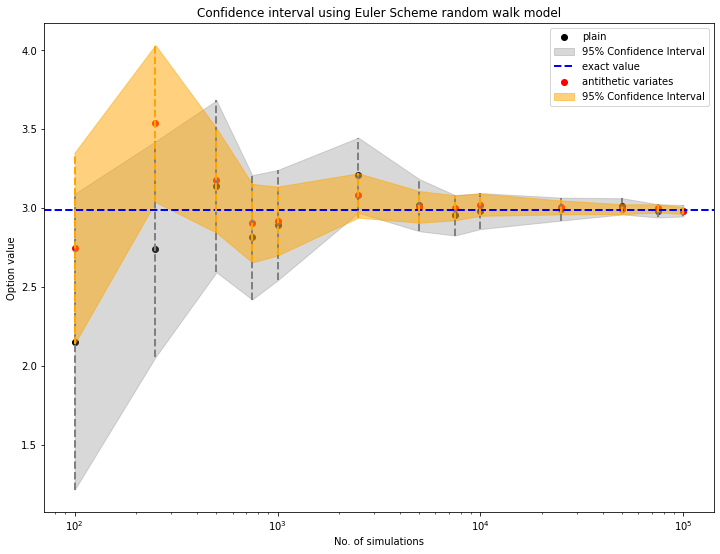

In [334]:
plot_Asian_confidence_interval(result_test_1_2, result_test_2_2, 1, 2, 'Euler Scheme', gac)

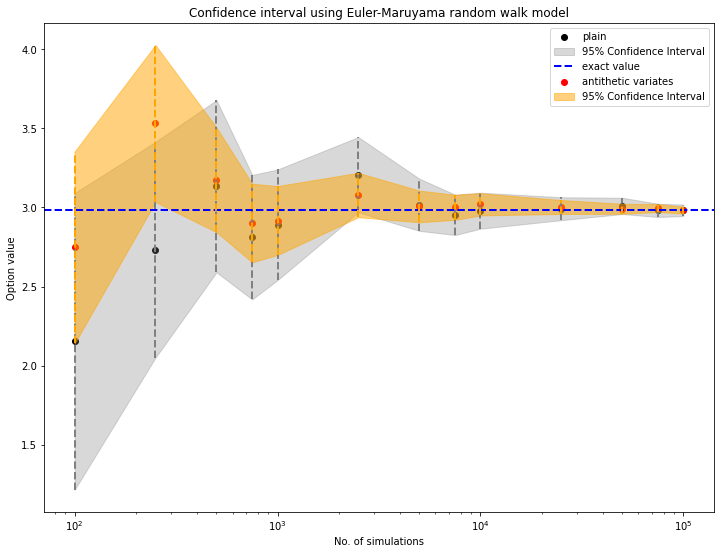

In [335]:
plot_Asian_confidence_interval(result_test_1_2, result_test_2_2, 4, 5, 'Euler-Maruyama', gac)

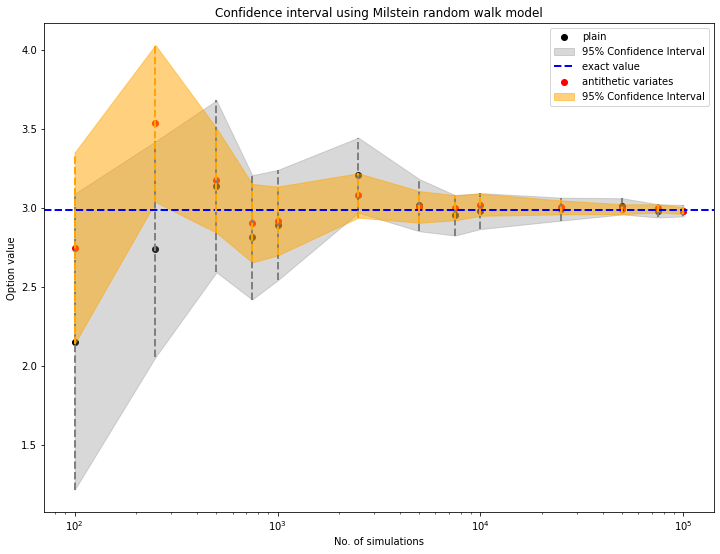

In [329]:
plot_Asian_confidence_interval(result_test_1_2, result_test_2_2, 7, 8, 'Milstein', gac)

In [332]:
latex_result_test_1_2 = result_test_1_2.to_latex(index=False, escape=False)
print(latex_result_test_1_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        2.1525 &  0.47836 &  0.0035 &          2.1531 &  0.47860 &  0.0014 &    2.1523 &  0.47831 &  0.0016 \\
   250 &        2.7379 &  0.34885 &  0.0053 &          2.7322 &  0.34837 &  0.0017 &    2.7376 &  0.34882 &  0.0043 \\
   500 &        3.1371 &  0.27773 &  0.0119 &          3.1342 &  0.27763 &  0.0064 &    3.1367 &  0.27770 &  0.0051 \\
   750 &        2.8139 &  0.20103 &  0.0135 &          2.8122 &  0.20080 &  0.0071 &    2.8135 &  0.20100 &  0.0083 \\
  1000 &        2.8906 &  0.17842 &  0.0166 &          2.8903 &  0.17843 &  0.0075 &    2.8903 &  0.17840 &  0.0085 \\
  2500 &        3.2076 &  0.12140 &  0.0438 &          3.2073 &  0.12134 &  0.0218 &    3.2072 &  0.12139 &  0.0275 \\
  5000 &        3.0177 &  0.08419 &  0.1018 &          3.0171 &  0.08415 &  0.0503 &    3.0173 &  0.08419 &  0.0559 \\
  

In [333]:
latex_result_test_2_2 = result_test_2_2.to_latex(index=False, escape=False)
print(latex_result_test_2_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        2.7454 &  0.30910 &  0.0029 &          2.7471 &  0.30954 &  0.0021 &    2.7451 &  0.30907 &  0.0038 \\
   250 &        3.5352 &  0.25368 &  0.0065 &          3.5310 &  0.25318 &  0.0048 &    3.5347 &  0.25366 &  0.0045 \\
   500 &        3.1747 &  0.16898 &  0.0102 &          3.1749 &  0.16888 &  0.0077 &    3.1743 &  0.16896 &  0.0094 \\
   750 &        2.9037 &  0.12693 &  0.0166 &          2.9017 &  0.12679 &  0.0112 &    2.9034 &  0.12692 &  0.0135 \\
  1000 &        2.9173 &  0.11129 &  0.0182 &          2.9174 &  0.11120 &  0.0138 &    2.9170 &  0.11128 &  0.0178 \\
  2500 &        3.0791 &  0.07167 &  0.0562 &          3.0788 &  0.07164 &  0.0428 &    3.0788 &  0.07167 &  0.0526 \\
  5000 &        3.0068 &  0.05115 &  0.1729 &          3.0065 &  0.05113 &  0.2296 &    3.0064 &  0.05114 &  0.1178 \\
  

### European average rate Asian Put Option - Average price of full length of contract

In [338]:
T1 = date(2024,1,1)
gap = geometric_avg_put_option(S0, K, r, sigma, T)
display(pd.DataFrame({'Exact value': [round(gap, 4)]}))

Exact value
0       6.6983

In [339]:
[put_test_1_2, put_test_2_2] = generate_Asian_results('p', "average_rate", "geometric")
print("Basic realisation paths")
display(put_test_1_2)
print("Antithetic variate paths")
display(put_test_2_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        5.6733  0.64791  0.0027          5.6710  0.64796  0.0009   
1      250        6.9465  0.50376  0.0271          6.9492  0.50385  0.0025   
2      500        6.4207  0.33145  0.0224          6.4168  0.33143  0.0110   
3      750        6.5147  0.26809  0.0321          6.5148  0.26824  0.0073   
4     1000        6.7221  0.23106  0.0210          6.7233  0.23116  0.0089   
5     2500        6.6769  0.14695  0.0650          6.6769  0.14701  0.0217   
6     5000        6.8575  0.10632  0.0968          6.8573  0.10636  0.0449   
7     7500        6.5878  0.08612  0.1227          6.5872  0.08614  0.0583   
8    10000        6.6474  0.07378  0.1597          6.6463  0.07380  0.0747   
9    25000        6.7159  0.04724  0.8527          6.7155  0.04725  0.2997   
10   50000        6.7602  0.03358  1.2758          6.7596  0.03359  0.7112   
11   75000        6.7255  0.02715  1.4123          6.7250  0.02716  0.9016   
12  100000        6.6538  0.02346  1.7243          6.6534  0.02347  1.1644   

    Milstein  Error_3  Time_3  
0     5.6731  0.64787  0.0011  
1     6.9462  0.50373  0.0035  
2     6.4204  0.33143  0.0057  
3     6.5143  0.26808  0.0070  
4     6.7218  0.23104  0.0087  
5     6.6765  0.14694  0.0252  
6     6.8572  0.10631  0.0566  
7     6.5875  0.08612  0.0692  
8     6.6470  0.07377  0.0937  
9     6.7156  0.04724  0.4143  
10    6.7598  0.03358  0.8786  
11    6.7252  0.02715  1.1551  
12    6.6534  0.02346  1.6403

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        6.0838  0.20477  0.0521          6.0832  0.20495  0.0092   
1      250        7.0345  0.17655  0.0077          7.0364  0.17658  0.0052   
2      500        6.6462  0.11633  0.0104          6.6434  0.11648  0.0137   
3      750        6.7672  0.09497  0.0147          6.7667  0.09517  0.0108   
4     1000        6.6142  0.07983  0.0195          6.6140  0.07994  0.0141   
5     2500        6.7092  0.05398  0.0493          6.7094  0.05405  0.0384   
6     5000        6.7875  0.03806  0.1176          6.7871  0.03811  0.1197   
7     7500        6.7351  0.03079  0.1316          6.7349  0.03082  0.1117   
8    10000        6.6799  0.02630  0.2098          6.6789  0.02633  0.1605   
9    25000        6.7151  0.01686  0.6279          6.7144  0.01688  0.5142   
10   50000        6.7286  0.01201  1.9494          6.7280  0.01203  1.4980   
11   75000        6.7042  0.00973  3.2659          6.7036  0.00974  2.0900   
12  100000        6.7102  0.00844  3.7849          6.7098  0.00845  4.4285   

    Milstein  Error_3  Time_3  
0     6.0835  0.20475  0.0048  
1     7.0341  0.17654  0.0103  
2     6.6458  0.11632  0.0108  
3     6.7668  0.09496  0.0137  
4     6.6138  0.07983  0.0186  
5     6.7089  0.05398  0.0507  
6     6.7872  0.03806  0.2304  
7     6.7348  0.03078  0.1612  
8     6.6795  0.02629  0.2248  
9     6.7147  0.01686  0.9874  
10    6.7282  0.01201  2.7467  
11    6.7038  0.00972  4.2171  
12    6.7099  0.00844  4.0936

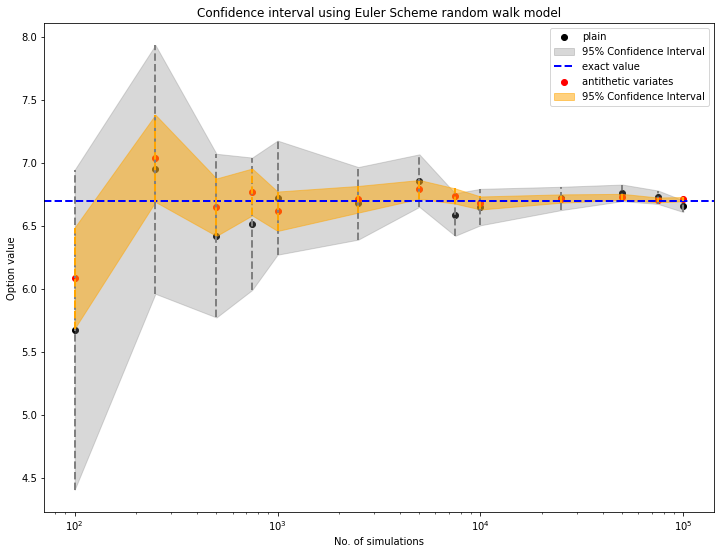

In [343]:
plot_Asian_confidence_interval(put_test_1_2, put_test_2_2, 1, 2, 'Euler Scheme', gap)

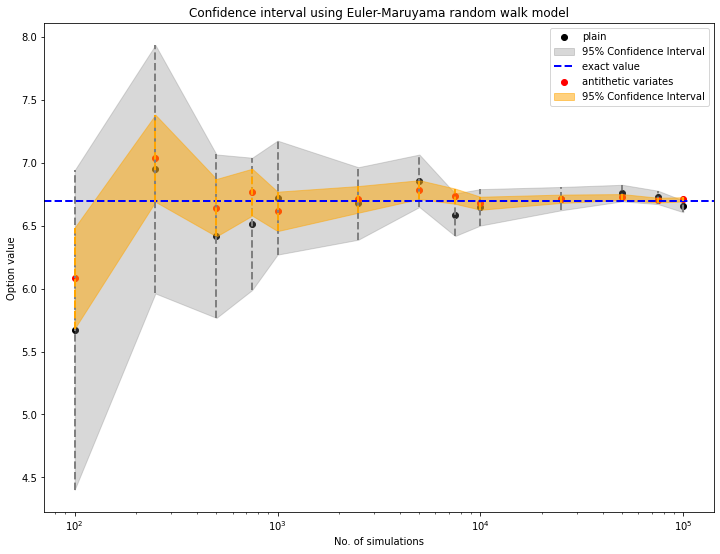

In [344]:
plot_Asian_confidence_interval(put_test_1_2, put_test_2_2, 4, 5, 'Euler-Maruyama', gap)

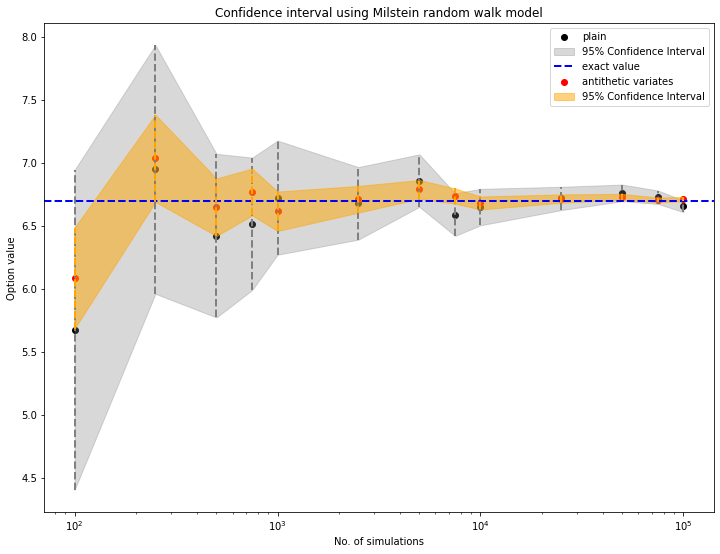

In [342]:
plot_Asian_confidence_interval(put_test_1_2, put_test_2_2, 7, 8, 'Milstein', gap)

In [340]:
latex_put_test_1_2 = put_test_1_2.to_latex(index=False, escape=False)
print(latex_put_test_1_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        5.6733 &  0.64791 &  0.0027 &          5.6710 &  0.64796 &  0.0009 &    5.6731 &  0.64787 &  0.0011 \\
   250 &        6.9465 &  0.50376 &  0.0271 &          6.9492 &  0.50385 &  0.0025 &    6.9462 &  0.50373 &  0.0035 \\
   500 &        6.4207 &  0.33145 &  0.0224 &          6.4168 &  0.33143 &  0.0110 &    6.4204 &  0.33143 &  0.0057 \\
   750 &        6.5147 &  0.26809 &  0.0321 &          6.5148 &  0.26824 &  0.0073 &    6.5143 &  0.26808 &  0.0070 \\
  1000 &        6.7221 &  0.23106 &  0.0210 &          6.7233 &  0.23116 &  0.0089 &    6.7218 &  0.23104 &  0.0087 \\
  2500 &        6.6769 &  0.14695 &  0.0650 &          6.6769 &  0.14701 &  0.0217 &    6.6765 &  0.14694 &  0.0252 \\
  5000 &        6.8575 &  0.10632 &  0.0968 &          6.8573 &  0.10636 &  0.0449 &    6.8572 &  0.10631 &  0.0566 \\
  

In [341]:
latex_put_test_2_2 = put_test_2_2.to_latex(index=False, escape=False)
print(latex_put_test_2_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        6.0838 &  0.20477 &  0.0521 &          6.0832 &  0.20495 &  0.0092 &    6.0835 &  0.20475 &  0.0048 \\
   250 &        7.0345 &  0.17655 &  0.0077 &          7.0364 &  0.17658 &  0.0052 &    7.0341 &  0.17654 &  0.0103 \\
   500 &        6.6462 &  0.11633 &  0.0104 &          6.6434 &  0.11648 &  0.0137 &    6.6458 &  0.11632 &  0.0108 \\
   750 &        6.7672 &  0.09497 &  0.0147 &          6.7667 &  0.09517 &  0.0108 &    6.7668 &  0.09496 &  0.0137 \\
  1000 &        6.6142 &  0.07983 &  0.0195 &          6.6140 &  0.07994 &  0.0141 &    6.6138 &  0.07983 &  0.0186 \\
  2500 &        6.7092 &  0.05398 &  0.0493 &          6.7094 &  0.05405 &  0.0384 &    6.7089 &  0.05398 &  0.0507 \\
  5000 &        6.7875 &  0.03806 &  0.1176 &          6.7871 &  0.03811 &  0.1197 &    6.7872 &  0.03806 &  0.2304 \\
  

### European average rate Asian Call Option - Average of 30 days before expiry

In [403]:
phis = np.random.normal(0, 1, size=(N,M))
T1 = date(2024,12,1)
start_time = time.time()
mil_simulator = Milstein_fast_simulator("Milstein", S0, K, r, sigma, T, N, M, T0, T2, phis)
asian_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1, mil_simulator)
asian_option.run_monte_carlo(antithetic_variates=True)
(asian_pric_30, SE_30) = asian_option.get_average_rate_Asian_price('c', "geometric")
print("Geometric average rate Call: value is {0} with standard error {1}".format(round(asian_pric_30,4), round(SE_30,3)))
print("Computation time is: ", round(time.time() - start_time,4))

Geometric average rate Call: value is 3.3775 with standard error 0.125
Computation time is:  0.0509


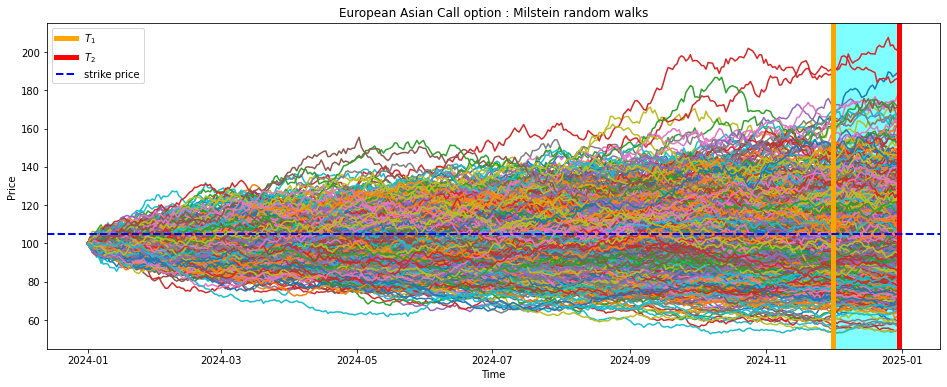

In [404]:
asian_option.plot_asian_paths()

In [391]:
T1 = date(2024,12,1)
[result_30_1, result_30_2] = generate_Asian_results('c', "average_rate", "geometric")
print("Basic realisation paths")
display(result_30_1)
print("Antithetic variate paths")
display(result_30_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        3.3111  0.60469  0.0055          3.3087  0.60497  0.0025   
1      250        3.4521  0.38269  0.0060          3.4488  0.38235  0.0017   
2      500        3.4757  0.30365  0.0094          3.4791  0.30392  0.0042   
3      750        3.5669  0.23297  0.0155          3.5637  0.23271  0.0086   
4     1000        3.6138  0.20926  0.0176          3.6137  0.20927  0.0082   
5     2500        3.6480  0.13795  0.0578          3.6460  0.13780  0.0236   
6     5000        3.3937  0.09225  0.1607          3.3928  0.09218  0.0550   
7     7500        3.4827  0.07682  0.1470          3.4828  0.07678  0.0641   
8    10000        3.4615  0.06576  0.2071          3.4613  0.06573  0.0973   
9    25000        3.4226  0.04154  0.6607          3.4226  0.04152  0.2606   
10   50000        3.4382  0.02944  1.6105          3.4379  0.02943  0.7043   
11   75000        3.3881  0.02384  1.6569          3.3873  0.02383  0.9250   
12  100000        3.4418  0.02083  2.2045          3.4413  0.02082  1.3594   

    Milstein  Error_3  Time_3  
0     3.3106  0.60463  0.0042  
1     3.4517  0.38266  0.0050  
2     3.4753  0.30362  0.0055  
3     3.5665  0.23295  0.0069  
4     3.6133  0.20923  0.0097  
5     3.6476  0.13793  0.0285  
6     3.3933  0.09224  0.1288  
7     3.4823  0.07681  0.0902  
8     3.4610  0.06575  0.1554  
9     3.4222  0.04154  0.3408  
10    3.4378  0.02944  0.9080  
11    3.3877  0.02384  1.2925  
12    3.4414  0.02083  1.6672

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        3.2191  0.35522  0.0044          3.2202  0.35568  0.0050   
1      250        3.3450  0.23496  0.0114          3.3442  0.23508  0.0047   
2      500        3.5288  0.18092  0.0097          3.5328  0.18093  0.0071   
3      750        3.3029  0.13480  0.0138          3.3038  0.13473  0.0099   
4     1000        3.6747  0.13013  0.0186          3.6757  0.13008  0.0137   
5     2500        3.3472  0.08001  0.0525          3.3467  0.07992  0.0404   
6     5000        3.3857  0.05542  0.1734          3.3851  0.05538  0.0861   
7     7500        3.4527  0.04593  0.1716          3.4525  0.04590  0.1707   
8    10000        3.4252  0.03954  0.2145          3.4248  0.03951  0.1617   
9    25000        3.4389  0.02511  0.6157          3.4384  0.02510  0.4586   
10   50000        3.4287  0.01777  1.8512          3.4280  0.01776  1.2390   
11   75000        3.4222  0.01442  3.2032          3.4214  0.01441  3.4427   
12  100000        3.4336  0.01252  3.4040          3.4332  0.01252  2.6169   

    Milstein  Error_3  Time_3  
0     3.2187  0.35518  0.0044  
1     3.3447  0.23493  0.0042  
2     3.5284  0.18091  0.0085  
3     3.3025  0.13479  0.0121  
4     3.6743  0.13011  0.0183  
5     3.3468  0.08001  0.0736  
6     3.3853  0.05542  0.1306  
7     3.4523  0.04593  0.2257  
8     3.4248  0.03953  0.3015  
9     3.4385  0.02511  0.7828  
10    3.4283  0.01777  2.0998  
11    3.4217  0.01442  4.9393  
12    3.4332  0.01252  6.5162

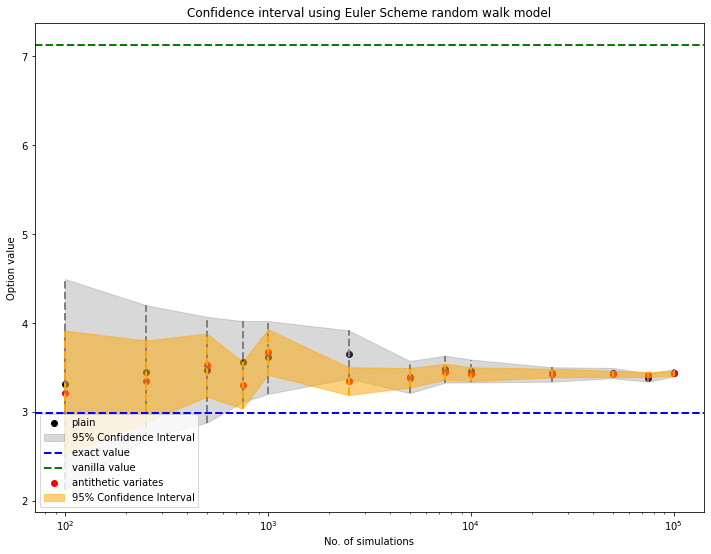

In [399]:
plot_Asian_confidence_interval(result_30_1, result_30_2, 1, 2, 'Euler Scheme', exact_val=2.9849, vanilla_val=7.1281
)

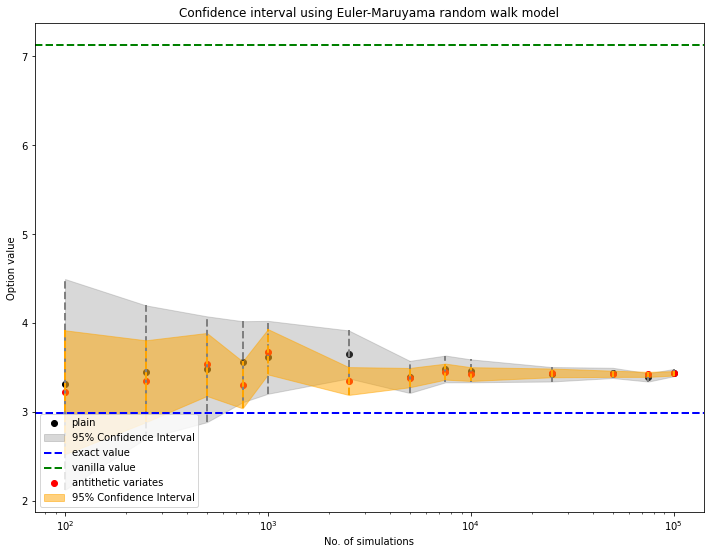

In [400]:
plot_Asian_confidence_interval(result_30_1, result_30_2, 4, 5, 'Euler-Maruyama', exact_val=2.9849, vanilla_val=7.1281
)

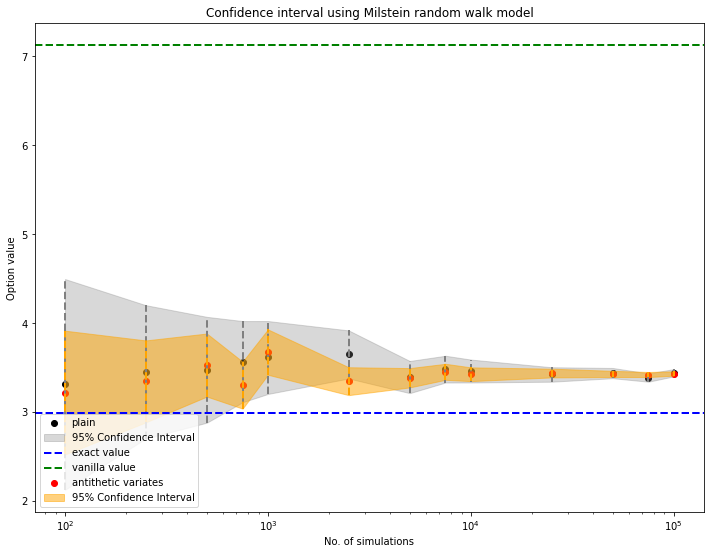

In [401]:
plot_Asian_confidence_interval(result_30_1, result_30_2, 7, 8, 'Milstein', exact_val=2.9849, vanilla_val=7.1281
)

In [402]:
latex_result_30_1 = result_30_1.to_latex(index=False, escape=False)
print(latex_result_30_1)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        3.3111 &  0.60469 &  0.0055 &          3.3087 &  0.60497 &  0.0025 &    3.3106 &  0.60463 &  0.0042 \\
   250 &        3.4521 &  0.38269 &  0.0060 &          3.4488 &  0.38235 &  0.0017 &    3.4517 &  0.38266 &  0.0050 \\
   500 &        3.4757 &  0.30365 &  0.0094 &          3.4791 &  0.30392 &  0.0042 &    3.4753 &  0.30362 &  0.0055 \\
   750 &        3.5669 &  0.23297 &  0.0155 &          3.5637 &  0.23271 &  0.0086 &    3.5665 &  0.23295 &  0.0069 \\
  1000 &        3.6138 &  0.20926 &  0.0176 &          3.6137 &  0.20927 &  0.0082 &    3.6133 &  0.20923 &  0.0097 \\
  2500 &        3.6480 &  0.13795 &  0.0578 &          3.6460 &  0.13780 &  0.0236 &    3.6476 &  0.13793 &  0.0285 \\
  5000 &        3.3937 &  0.09225 &  0.1607 &          3.3928 &  0.09218 &  0.0550 &    3.3933 &  0.09224 &  0.1288 \\
  

In [405]:
latex_result_30_2 = result_30_2.to_latex(index=False, escape=False)
print(latex_result_30_2)

\begin{tabular}{rrrrrrrrrr}
\toprule
     n &  Euler Scheme &  Error_1 &  Time_1 &  Euler-Maruyama &  Error_2 &  Time_2 &  Milstein &  Error_3 &  Time_3 \\
\midrule
   100 &        3.2191 &  0.35522 &  0.0044 &          3.2202 &  0.35568 &  0.0050 &    3.2187 &  0.35518 &  0.0044 \\
   250 &        3.3450 &  0.23496 &  0.0114 &          3.3442 &  0.23508 &  0.0047 &    3.3447 &  0.23493 &  0.0042 \\
   500 &        3.5288 &  0.18092 &  0.0097 &          3.5328 &  0.18093 &  0.0071 &    3.5284 &  0.18091 &  0.0085 \\
   750 &        3.3029 &  0.13480 &  0.0138 &          3.3038 &  0.13473 &  0.0099 &    3.3025 &  0.13479 &  0.0121 \\
  1000 &        3.6747 &  0.13013 &  0.0186 &          3.6757 &  0.13008 &  0.0137 &    3.6743 &  0.13011 &  0.0183 \\
  2500 &        3.3472 &  0.08001 &  0.0525 &          3.3467 &  0.07992 &  0.0404 &    3.3468 &  0.08001 &  0.0736 \\
  5000 &        3.3857 &  0.05542 &  0.1734 &          3.3851 &  0.05538 &  0.0861 &    3.3853 &  0.05542 &  0.1306 \\
  

In [289]:
[result_1_1, result_1_2] = generate_Asian_results('c', "average_rate", "arithmetic")
print("Basic realisation paths")
display(result_1_1)
print("Antithetic variate paths")
display(result_1_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        4.3841  0.76312  0.0030          4.3828  0.76233  0.0010   
1      250        3.9836  0.52012  0.0044          3.9804  0.51939  0.0017   
2      500        3.3791  0.26881  0.0098          3.3769  0.26886  0.0025   
3      750        3.3870  0.24243  0.0108          3.3845  0.24243  0.0056   
4     1000        3.1975  0.20837  0.0156          3.1963  0.20825  0.0055   
5     2500        3.3808  0.12991  0.0322          3.3792  0.12979  0.0132   
6     5000        3.5629  0.09840  0.0754          3.5608  0.09832  0.0270   
7     7500        3.5234  0.07840  0.2082          3.5238  0.07837  0.0458   
8    10000        3.5904  0.06932  0.1387          3.5887  0.06925  0.0586   
9    25000        3.5759  0.04318  0.3398          3.5749  0.04315  0.1410   
10   50000        3.5460  0.03003  0.7121          3.5453  0.03000  0.4007   
11   75000        3.5043  0.02443  1.0654          3.5036  0.02441  0.5988   
12  100000        3.5491  0.02132  1.4125          3.5483  0.02131  0.8035   

    Milstein  Error_3  Time_3  
0     4.3836  0.76303  0.0011  
1     3.9832  0.52007  0.0014  
2     3.3786  0.26878  0.0030  
3     3.3866  0.24241  0.0042  
4     3.1971  0.20834  0.0056  
5     3.3804  0.12989  0.0168  
6     3.5625  0.09839  0.0344  
7     3.5230  0.07839  0.0567  
8     3.5900  0.06931  0.0771  
9     3.5755  0.04317  0.1896  
10    3.5456  0.03002  0.5536  
11    3.5039  0.02443  0.8338  
12    3.5487  0.02132  1.1046

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        4.1266  0.47400  0.0038          4.1264  0.47340  0.0014   
1      250        3.9709  0.30800  0.0064          3.9713  0.30752  0.0030   
2      500        3.2272  0.16636  0.0080          3.2260  0.16638  0.0044   
3      750        3.5569  0.15154  0.0092          3.5542  0.15146  0.0059   
4     1000        3.3037  0.12366  0.0128          3.3024  0.12356  0.0080   
5     2500        3.4937  0.08080  0.0393          3.4929  0.08075  0.0271   
6     5000        3.5712  0.05895  0.0710          3.5689  0.05889  0.0392   
7     7500        3.6293  0.04740  0.1100          3.6291  0.04737  0.0704   
8    10000        3.6243  0.04173  0.1541          3.6235  0.04169  0.1047   
9    25000        3.5768  0.02590  0.3733          3.5761  0.02588  0.2551   
10   50000        3.5564  0.01818  1.3503          3.5558  0.01817  0.8956   
11   75000        3.5555  0.01484  1.9432          3.5548  0.01483  1.1363   
12  100000        3.5589  0.01282  2.5938          3.5581  0.01281  1.3836   

    Milstein  Error_3  Time_3  
0     4.1261  0.47395  0.0014  
1     3.9705  0.30797  0.0042  
2     3.2268  0.16635  0.0069  
3     3.5564  0.15153  0.0087  
4     3.3033  0.12364  0.0116  
5     3.4933  0.08079  0.0390  
6     3.5707  0.05895  0.0583  
7     3.6289  0.04740  0.1076  
8     3.6239  0.04172  0.1575  
9     3.5763  0.02590  0.3898  
10    3.5559  0.01818  1.1638  
11    3.5551  0.01484  1.7736  
12    3.5585  0.01282  4.4802

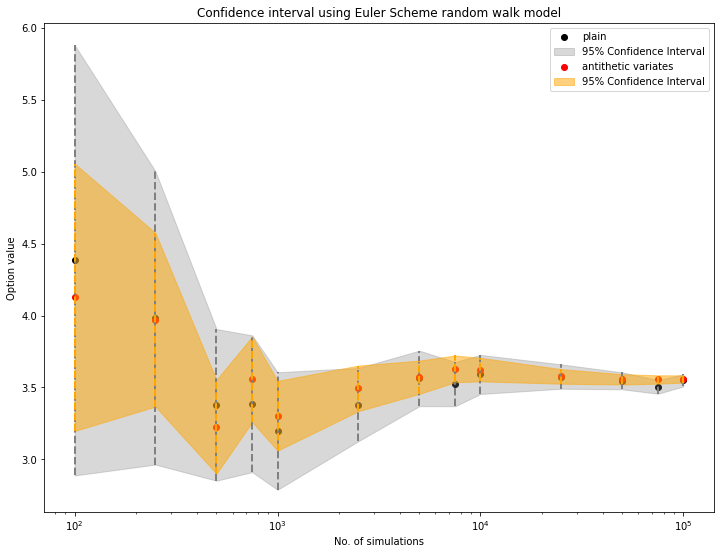

In [291]:
plot_Asian_confidence_interval(result_1_1, result_1_2, 1, 2, 'Euler Scheme')

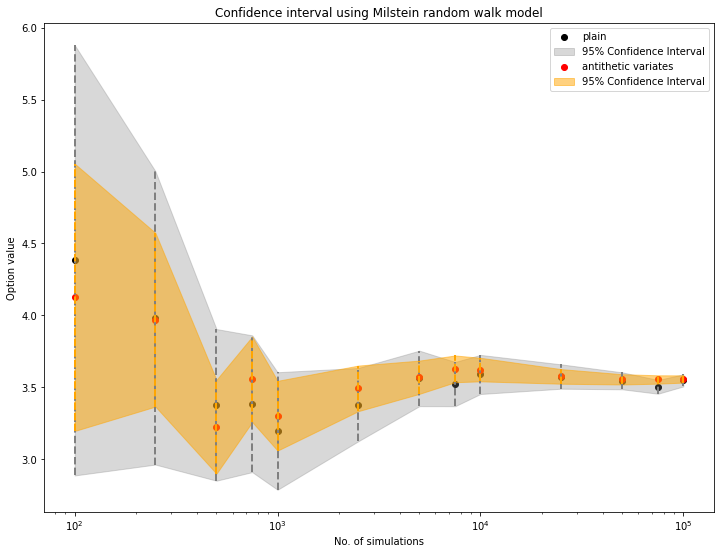

In [294]:
plot_Asian_confidence_interval(result_1_1, result_1_2, 7, 8, 'Milstein')

In [292]:
[result_2_1, result_2_2] = generate_Asian_results('c', "average_rate", "geometric")
print("Basic realisation paths")
display(result_2_1)
print("Antithetic variate paths")
display(result_2_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        3.0672  0.56208  0.0022          3.0665  0.56097  0.0007   
1      250        3.1133  0.43356  0.0037          3.1187  0.43360  0.0015   
2      500        3.8355  0.31161  0.0115          3.8384  0.31143  0.0057   
3      750        3.6391  0.25074  0.0121          3.6379  0.25065  0.0056   
4     1000        3.6657  0.22855  0.0177          3.6666  0.22842  0.0081   
5     2500        3.2648  0.12494  0.0452          3.2631  0.12486  0.0220   
6     5000        3.4259  0.09217  0.0765          3.4252  0.09213  0.0404   
7     7500        3.3631  0.07430  0.1417          3.3637  0.07428  0.0716   
8    10000        3.3528  0.06445  0.2077          3.3533  0.06443  0.0954   
9    25000        3.3553  0.04081  0.4629          3.3555  0.04079  0.2176   
10   50000        3.3958  0.02920  0.9107          3.3953  0.02918  0.5828   
11   75000        3.4022  0.02387  1.6307          3.4014  0.02386  1.0655   
12  100000        3.4178  0.02071  2.0454          3.4171  0.02069  1.2002   

    Milstein  Error_3  Time_3  
0     3.0668  0.56202  0.0011  
1     3.1130  0.43351  0.0225  
2     3.8350  0.31157  0.0047  
3     3.6387  0.25071  0.0079  
4     3.6653  0.22852  0.0085  
5     3.2644  0.12492  0.0268  
6     3.4255  0.09216  0.0699  
7     3.3627  0.07429  0.0957  
8     3.3524  0.06444  0.1138  
9     3.3549  0.04080  0.3103  
10    3.3954  0.02920  0.7243  
11    3.4018  0.02387  1.3801  
12    3.4174  0.02070  1.6281

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        3.4776  0.39794  0.0037          3.4776  0.39735  0.0027   
1      250        3.5222  0.27158  0.0082          3.5270  0.27145  0.0067   
2      500        3.4239  0.17864  0.0107          3.4236  0.17842  0.0072   
3      750        3.4334  0.14323  0.0136          3.4324  0.14311  0.0108   
4     1000        3.6393  0.13265  0.0185          3.6397  0.13262  0.0133   
5     2500        3.2764  0.07582  0.0515          3.2747  0.07578  0.0423   
6     5000        3.4327  0.05601  0.1319          3.4313  0.05596  0.2899   
7     7500        3.3671  0.04516  0.1478          3.3671  0.04514  0.1179   
8    10000        3.3713  0.03899  0.2105          3.3714  0.03896  0.1455   
9    25000        3.4071  0.02480  0.6671          3.4074  0.02479  0.4564   
10   50000        3.4072  0.01762  1.5627          3.4067  0.01760  1.0030   
11   75000        3.4152  0.01443  3.1244          3.4146  0.01442  2.0466   
12  100000        3.4052  0.01247  3.8628          3.4047  0.01246  2.4541   

    Milstein  Error_3  Time_3  
0     3.4772  0.39789  0.0023  
1     3.5217  0.27155  0.0049  
2     3.4235  0.17862  0.0090  
3     3.4330  0.14322  0.0131  
4     3.6389  0.13264  0.0174  
5     3.2760  0.07581  0.0557  
6     3.4323  0.05600  0.1460  
7     3.3667  0.04515  0.1407  
8     3.3709  0.03898  0.2353  
9     3.4067  0.02480  0.5346  
10    3.4068  0.01761  1.6132  
11    3.4148  0.01443  4.5854  
12    3.4048  0.01247  5.0648

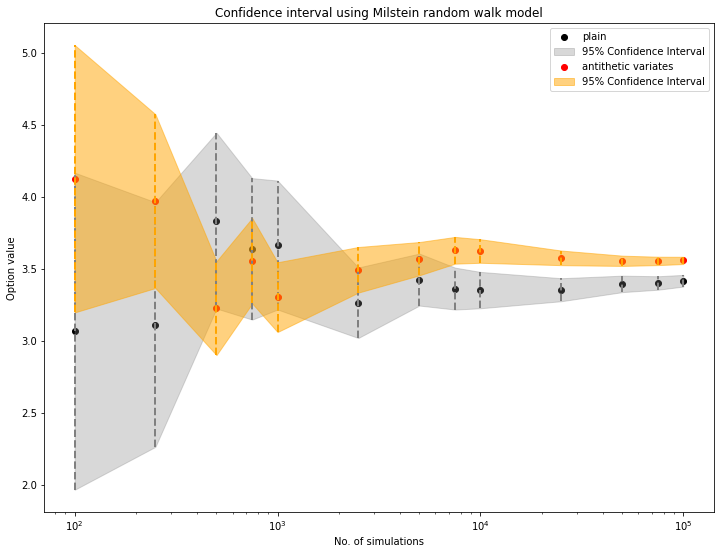

In [293]:
plot_Asian_confidence_interval(result_2_1, result_1_2, 7, 8, 'Milstein')

In [298]:
[result_3_1, result_3_2] = generate_Asian_results('c', "average_strike", "arithemetic")
print("Basic realisation paths")
display(result_3_1)
print("Antithetic variate paths")
display(result_3_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        6.7293  1.01458  0.0082          6.7400  1.01492  0.0017   
1      250        4.8566  0.48642  0.0080          4.8523  0.48587  0.0020   
2      500        4.9745  0.34515  0.0128          4.9703  0.34519  0.0077   
3      750        5.4227  0.29679  0.0188          5.4242  0.29651  0.0062   
4     1000        4.8231  0.23040  0.0191          4.8254  0.23027  0.0076   
5     2500        5.2127  0.16056  0.0512          5.2127  0.16054  0.0246   
6     5000        5.4648  0.11859  0.1111          5.4650  0.11852  0.0447   
7     7500        5.3660  0.09223  0.1394          5.3675  0.09222  0.0671   
8    10000        5.2978  0.07971  0.1623          5.2967  0.07967  0.0855   
9    25000        5.1934  0.05064  0.6289          5.1939  0.05061  0.3543   
10   50000        5.2368  0.03554  1.3253          5.2365  0.03553  0.5563   
11   75000        5.2257  0.02921  1.2326          5.2256  0.02919  0.7605   
12  100000        5.2361  0.02531  1.7239          5.2361  0.02529  1.2430   

    Milstein  Error_3  Time_3  
0     6.7287  1.01447  0.0047  
1     4.8562  0.48638  0.0043  
2     4.9741  0.34512  0.0045  
3     5.4222  0.29676  0.0106  
4     4.8227  0.23038  0.0135  
5     5.2123  0.16054  0.0270  
6     5.4644  0.11858  0.0686  
7     5.3656  0.09222  0.0845  
8     5.2974  0.07970  0.1388  
9     5.1930  0.05064  0.4247  
10    5.2364  0.03554  0.7142  
11    5.2252  0.02920  1.0958  
12    5.2357  0.02530  1.6098

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        5.9553  0.50808  0.0050          5.9604  0.50726  0.0024   
1      250        5.3201  0.26692  0.0502          5.3142  0.26677  0.0054   
2      500        5.3641  0.19246  0.0092          5.3614  0.19252  0.0081   
3      750        5.2773  0.15916  0.0141          5.2782  0.15899  0.0103   
4     1000        5.1745  0.12826  0.0199          5.1772  0.12802  0.0139   
5     2500        5.2145  0.08612  0.0487          5.2135  0.08606  0.0380   
6     5000        5.2772  0.06193  0.1647          5.2770  0.06187  0.2239   
7     7500        5.2781  0.04921  0.1616          5.2791  0.04920  0.1220   
8    10000        5.2353  0.04220  0.1964          5.2346  0.04217  0.1487   
9    25000        5.2175  0.02705  0.7448          5.2174  0.02703  0.4313   
10   50000        5.2208  0.01898  1.5766          5.2206  0.01896  1.2430   
11   75000        5.2212  0.01565  2.5027          5.2211  0.01564  2.3459   
12  100000        5.2332  0.01354  3.5456          5.2330  0.01353  2.6825   

    Milstein  Error_3  Time_3  
0     5.9548  0.50802  0.0047  
1     5.3196  0.26690  0.0047  
2     5.3637  0.19244  0.0101  
3     5.2769  0.15915  0.0131  
4     5.1741  0.12824  0.0177  
5     5.2140  0.08611  0.0564  
6     5.2767  0.06192  0.1311  
7     5.2777  0.04921  0.1694  
8     5.2349  0.04220  0.2006  
9     5.2171  0.02705  0.6809  
10    5.2204  0.01898  2.5870  
11    5.2208  0.01565  3.1333  
12    5.2328  0.01354  4.5756

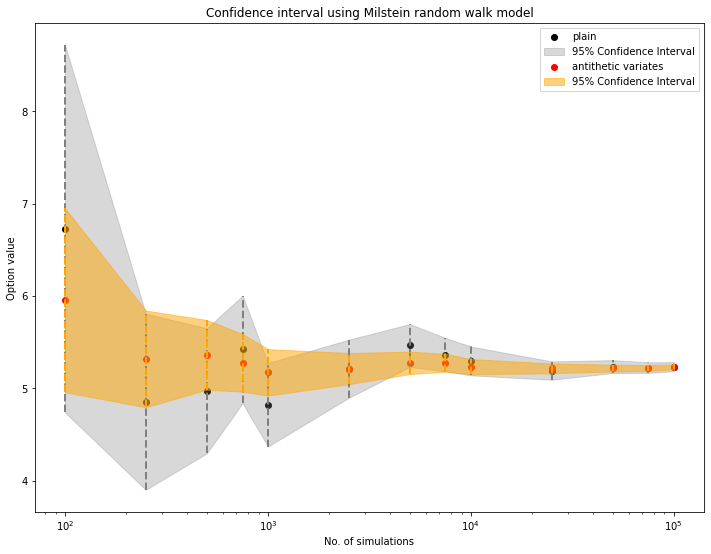

In [299]:
plot_Asian_confidence_interval(result_3_1, result_3_2, 7, 8, 'Milstein')

In [300]:
[result_4_1, result_4_2] = generate_Asian_results('c', "average_strike", "geometric")
print("Basic realisation paths")
display(result_4_1)
print("Antithetic variate paths")
display(result_4_2)


Basic realisation paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        4.7856  0.75297  0.0041          4.7842  0.75196  0.0012   
1      250        5.4463  0.45994  0.0059          5.4513  0.45961  0.0025   
2      500        5.4401  0.38016  0.0183          5.4415  0.38020  0.0060   
3      750        5.5733  0.29060  0.0133          5.5748  0.29056  0.0056   
4     1000        4.9710  0.24751  0.0180          4.9727  0.24738  0.0078   
5     2500        5.4928  0.16399  0.0430          5.4932  0.16385  0.0198   
6     5000        5.2240  0.11300  0.0820          5.2258  0.11295  0.0421   
7     7500        5.2215  0.09331  0.1210          5.2226  0.09325  0.0604   
8    10000        5.2000  0.08015  0.1737          5.1999  0.08011  0.0871   
9    25000        5.2298  0.05036  0.4940          5.2302  0.05033  0.2651   
10   50000        5.2344  0.03569  1.2464          5.2342  0.03567  0.6314   
11   75000        5.2081  0.02907  1.5319          5.2078  0.02905  0.9225   
12  100000        5.2328  0.02522  2.1318          5.2328  0.02521  1.3944   

    Milstein  Error_3  Time_3  
0     4.7853  0.75290  0.0010  
1     5.4459  0.45990  0.0060  
2     5.4397  0.38012  0.0050  
3     5.5729  0.29057  0.0062  
4     4.9707  0.24749  0.0103  
5     5.4924  0.16398  0.0232  
6     5.2235  0.11299  0.0536  
7     5.2211  0.09331  0.0719  
8     5.1996  0.08014  0.1218  
9     5.2294  0.05036  0.3363  
10    5.2340  0.03568  0.9026  
11    5.2077  0.02906  1.1047  
12    5.2324  0.02522  2.4087

Antithetic variate paths


n  Euler Scheme  Error_1  Time_1  Euler-Maruyama  Error_2  Time_2  \
0      100        4.8112  0.39798  0.0036          4.8163  0.39752  0.0022   
1      250        5.0125  0.23276  0.0082          5.0152  0.23232  0.0059   
2      500        5.5548  0.20347  0.0149          5.5560  0.20329  0.0105   
3      750        5.2605  0.15356  0.0138          5.2606  0.15352  0.0122   
4     1000        5.3102  0.13563  0.0188          5.3122  0.13549  0.0137   
5     2500        5.2366  0.08655  0.0484          5.2373  0.08645  0.0374   
6     5000        5.2161  0.06106  0.1047          5.2167  0.06099  0.0796   
7     7500        5.3255  0.05048  0.1544          5.3257  0.05043  0.1183   
8    10000        5.2611  0.04286  0.2162          5.2608  0.04282  0.1603   
9    25000        5.2394  0.02703  0.6035          5.2397  0.02701  0.4857   
10   50000        5.2659  0.01922  1.9071          5.2657  0.01920  1.2218   
11   75000        5.2003  0.01554  2.5120          5.1999  0.01553  1.9879   
12  100000        5.2310  0.01348  4.0777          5.2311  0.01347  4.7983   

    Milstein  Error_3  Time_3  
0     4.8109  0.39794  0.0036  
1     5.0121  0.23274  0.0064  
2     5.5543  0.20345  0.0109  
3     5.2601  0.15355  0.0130  
4     5.3097  0.13561  0.0176  
5     5.2362  0.08654  0.0490  
6     5.2157  0.06105  0.2230  
7     5.3251  0.05048  0.1631  
8     5.2607  0.04285  0.2424  
9     5.2389  0.02703  0.6748  
10    5.2655  0.01921  1.7393  
11    5.1999  0.01554  5.4300  
12    5.2305  0.01348  5.7427

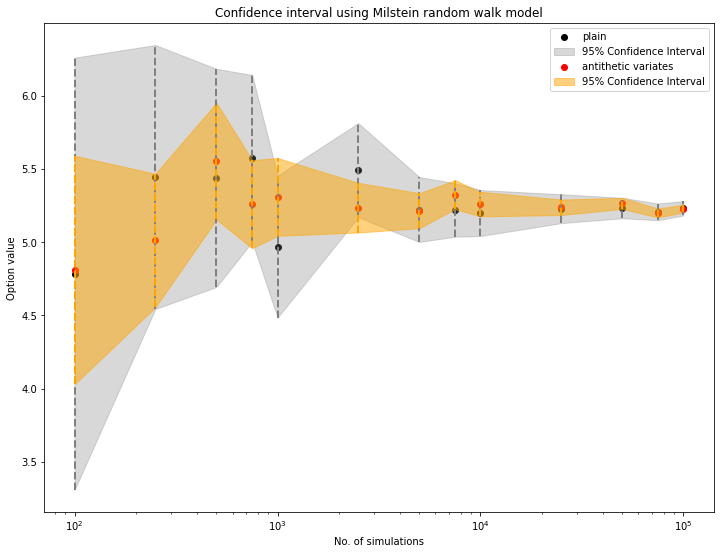

In [301]:
plot_Asian_confidence_interval(result_4_1, result_4_2, 7, 8, 'Milstein')

### European Asian Call Option - Average of 60 days before expiry

In [66]:
T1_60 = date(2023,11,1)
asian_call_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_call_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_call_option_60.get_European_option_price('c')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_call_option_60.get_Asian_price('c')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_call_option_60.main_type, asian_call_option_60.main_type, asian_call_option_60.title, asian_call_option_60.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

Start running simulations...


Method                 Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Call         0.350749        0.052280
1        Milstein                        Call         0.350849        0.052407
2  Euler-Maruyama  European Asian Call option         0.015834        0.008283
3        Milstein  European Asian Call option         0.015924        0.008323

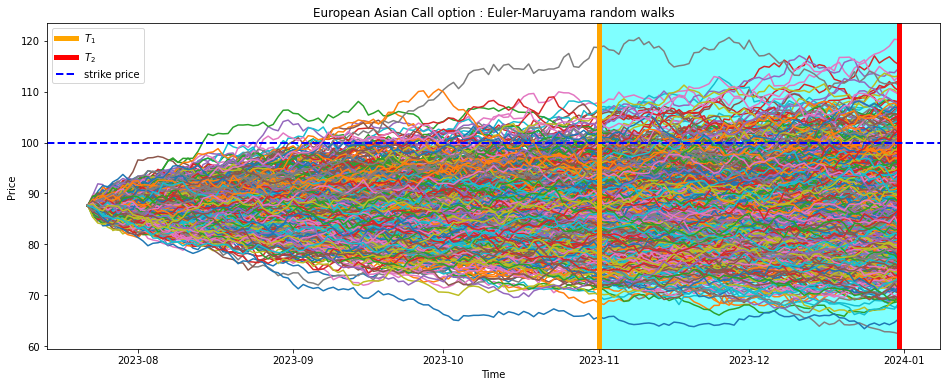

In [67]:
asian_call_option_60.plot_asian_paths()

### European Asian Put Option - Average of 30 days before expiry

In [68]:
asian_put_option = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1)
asian_put_option.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein"],
        'Option Type': [asian_put_option.main_type, asian_put_option.main_type, asian_put_option.title, asian_put_option.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE]
    }
)
results

Start running simulations...


Method                Option Type  Estimated Price  Standard Error
0  Euler-Maruyama                        Put        12.410515        0.255334
1        Milstein                        Put        12.410650        0.255375
2  Euler-Maruyama  European Asian Put option        10.566997        0.156631
3        Milstein  European Asian Put option        10.567672        0.156621

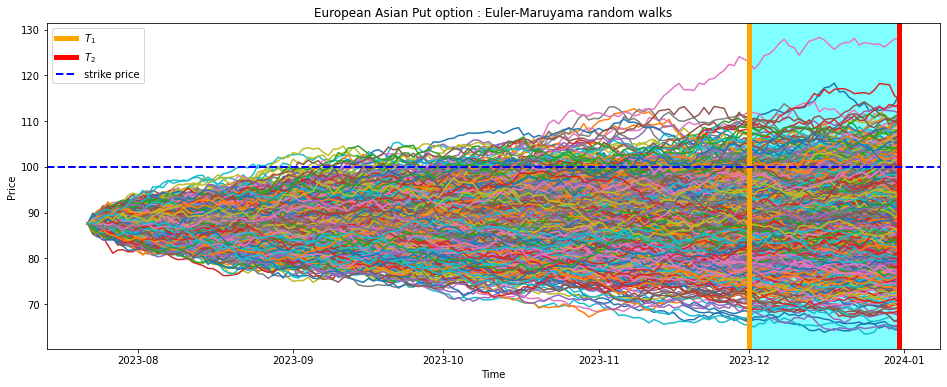

In [69]:
asian_put_option.plot_asian_paths()

### European Asian Put Option - Average of 60 days before expiry

In [70]:
T1_60 = date(2023,11,1)
asian_put_option_60 = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_put_option_60.run_monte_carlo()
(EM_option_price, M_option_price, EM_SE, M_SE) = asian_put_option_60.get_European_option_price('p')
(EM_asian_price, M_asian_price, EM_Asian_SE, M_Asian_SE) = asian_put_option_60.get_Asian_price('p')

asian_put_option_60av = AsianOption(S0, K, r, sigma, T, N, M, T0, T2, T1_60)
asian_put_option_60av.run_monte_carlo(antithetic_variates=True)
(EM_asian_price_av, M_asian_price_av, EM_Asian_SE_av, M_Asian_SE_av) = asian_put_option_60av.get_Asian_price('p')

results = pd.DataFrame(
    {
        'Method': ["Euler-Maruyama", "Milstein", "Euler-Maruyama", "Milstein", "Euler-Maruyama with antithetic variates", "Milstein with antithetic variates"],
        'Option Type': [asian_call_option.main_type, asian_call_option.main_type, asian_call_option.title, asian_call_option.title, asian_call_option_av.title, asian_call_option_av.title],
        'Estimated Price': [EM_option_price, M_option_price, EM_asian_price, M_asian_price, EM_asian_price_av, M_asian_price_av],
        'Standard Error': [EM_SE, M_SE, EM_Asian_SE, M_Asian_SE, EM_Asian_SE_av, M_Asian_SE_av]
    }
)
results

Start running simulations...
Start running simulations...


Method                 Option Type  \
0                           Euler-Maruyama                        Call   
1                                 Milstein                        Call   
2                           Euler-Maruyama  European Asian Call option   
3                                 Milstein  European Asian Call option   
4  Euler-Maruyama with antithetic variates  European Asian Call option   
5        Milstein with antithetic variates  European Asian Call option   

   Estimated Price  Standard Error  
0        11.935685        0.247867  
1        11.935400        0.247896  
2        10.623609        0.149418  
3        10.624666        0.149396  
4        10.952198        0.158612  
5        10.953151        0.158618

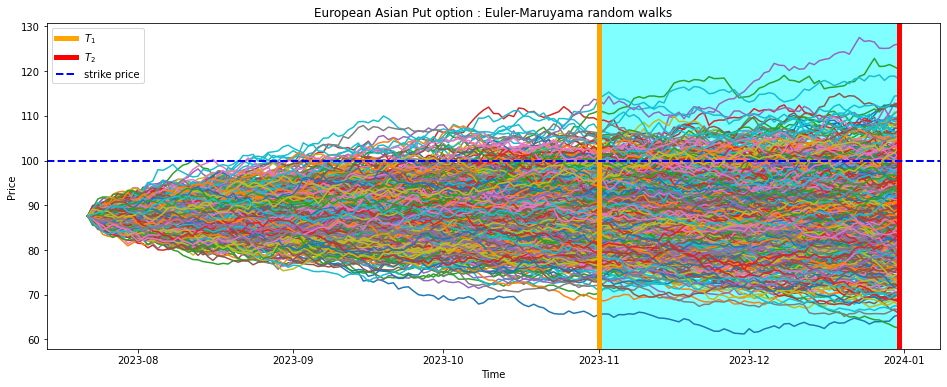

In [71]:
asian_put_option_60.plot_asian_paths()

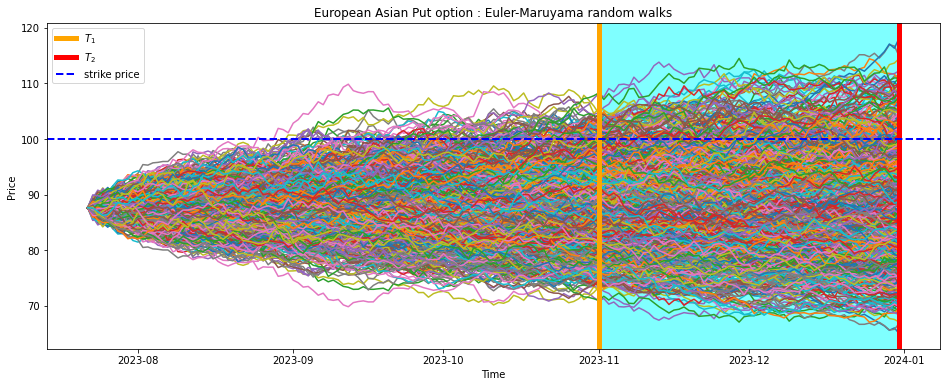

In [72]:
asian_put_option_60av.plot_asian_paths()